# Importation des librairies

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

import warnings

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report, accuracy_score
from imblearn.metrics import classification_report_imbalanced



#warnings.filterwarnings("ignore")

# Lecture du fichier data_cleaned_final_sans_dummies.csv

In [25]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  float64
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  float64
 7   atm             447136 non-null  float64
 8   col             447136 non-null  float64
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  float64
 13  prof            447136 non-null  float64
 14  plan            447136 non-null  float64
 15  surf            447136 non-null  float64
 16  infra           447136 non-null  float64
 17  situ           

In [27]:
cat = ['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ',
       'prof', 'plan', 'surf', 'infra', 'situ', 'grav', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'place_rec',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc']
df[cat] = df[cat].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447136 entries, 0 to 494017
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   jour            447136 non-null  int64  
 1   mois            447136 non-null  int64  
 2   an              447136 non-null  int64  
 3   lum             447136 non-null  int64  
 4   dep             447136 non-null  object 
 5   agg             447136 non-null  int64  
 6   int             447136 non-null  int64  
 7   atm             447136 non-null  int64  
 8   col             447136 non-null  int64  
 9   lat             447136 non-null  float64
 10  long            447136 non-null  float64
 11  catr            447136 non-null  int64  
 12  circ            447136 non-null  int64  
 13  prof            447136 non-null  int64  
 14  plan            447136 non-null  int64  
 15  surf            447136 non-null  int64  
 16  infra           447136 non-null  int64  
 17  situ           

Suppression des variables inutiles

In [28]:
df = df.drop(['an','jour', 'grav_rec', 'date', 'dep'], axis=1)

Renumérotation de la variable cible

In [29]:
df['grav'] = df['grav'].replace([1, 2, 3, 4], [0, 1, 2, 3])

# Séparation en train et test

Séparation des données de la cible

In [30]:
X = df.drop('grav', axis = 1)
y = df['grav']

y.value_counts(normalize = True)

grav
0    0.412733
3    0.403430
2    0.156550
1    0.027287
Name: proportion, dtype: float64

Séparation en train et test en gardant la même porportion de chaque modalité de la cible dans les jeux d'entraînement et de test.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

grav
0    0.412733
3    0.403430
2    0.156549
1    0.027288
Name: proportion, dtype: float64
grav
0    0.412733
3    0.403430
2    0.156552
1    0.027285
Name: proportion, dtype: float64


In [32]:
X_train.shape

(335352, 35)

Normalisation des données

In [33]:
# Normalisation de 'heure' et 'mois' pour X_train et X_test
X_train['heure_sin'] = np.sin(X_train['heure']*(2.*np.pi/24))
X_train['heure_cos'] = np.cos(X_train['heure']*(2.*np.pi/24))

X_train['mois_sin'] = np.sin(X_train['mois']*(2.*np.pi/24))
X_train['mois_cos'] = np.cos(X_train['mois']*(2.*np.pi/24))

X_test['heure_sin'] = np.sin(X_test['heure']*(2.*np.pi/24))
X_test['heure_cos'] = np.cos(X_test['heure']*(2.*np.pi/24))

X_test['mois_sin'] = np.sin(X_test['mois']*(2.*np.pi/24))
X_test['mois_cos'] = np.cos(X_test['mois']*(2.*np.pi/24))

X_train = X_train.drop(['heure', 'mois'], axis = 1)
X_test = X_test.drop(['heure', 'mois'], axis = 1)

In [34]:
# Normalisation de 'lat' et 'long'
scaler1 = RobustScaler()
X_train[['lat', 'long']] = scaler1.fit_transform(X_train[['lat', 'long']])
X_test[['lat', 'long']] = scaler1.transform(X_test[['lat', 'long']])

In [35]:
# Normalisation 'age_usager'
scaler1 = StandardScaler()
X_train[['age_usager']] = scaler1.fit_transform(X_train[['age_usager']])
X_test[['age_usager']] = scaler1.transform(X_test[['age_usager']])

# Oversampling sur le jeu de données

In [36]:
rOs = RandomOverSampler()
X_train_ro, y_train_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_train_ro).value_counts()))

Classes échantillon oversampled : {3: 138411, 2: 138411, 0: 138411, 1: 138411}


# Construction et entraînement du modèle

### Calbacks

In [37]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 0.01,
                                        patience = 5,
                                        factor = 0.5, 
                                        cooldown = 2,
                                        verbose = 1)

### Modèle 1 : Modèle de base

In [35]:
model1 = Sequential()
model1.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
model1.add(Dense(units = 140, activation = 'relu'))
model1.add(Dropout(rate = 0.2))
model1.add( Dense(units = 70, activation = 'relu'))
model1.add(Dense(units = 35, activation = 'relu'))
model1.add(Dropout(rate = 0.2))
model1.add(Dense(units = 14, activation = 'relu'))
model1.add(Dense(units = 4, activation = 'softmax'))

model1.summary()

/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_366 (Dense)               │ (None, 70)             │         2,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 140)            │         9,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 70)             │         9,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 35)             │         2,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_370 (Dense)               │ (None, 14)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 4)              │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,519 (99.68 KB)

 Trainable params: 25,519 (99.68 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model1.compile(loss = "sparse_categorical_crossentropy",
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])

In [37]:
history1 = model1.fit(X_train_ro, y_train_ro, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])

Epoch 1/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1214 - sparse_categorical_accuracy: 0.5026 - val_loss: 1.5171 - val_sparse_categorical_accuracy: 0.0692 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9809 - sparse_categorical_accuracy: 0.5811 - val_loss: 1.4464 - val_sparse_categorical_accuracy: 0.0651 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9530 - sparse_categorical_accuracy: 0.5930 - val_loss: 1.4709 - val_sparse_categorical_accuracy: 0.1157 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.6009 - val_loss: 1.4026 - val_sparse_categorical_accuracy: 0.1406 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9219 - sparse_categorical_accuracy: 0.6064 - val_loss: 1.4227 - val_sparse_categorical_accuracy: 0.1536 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2

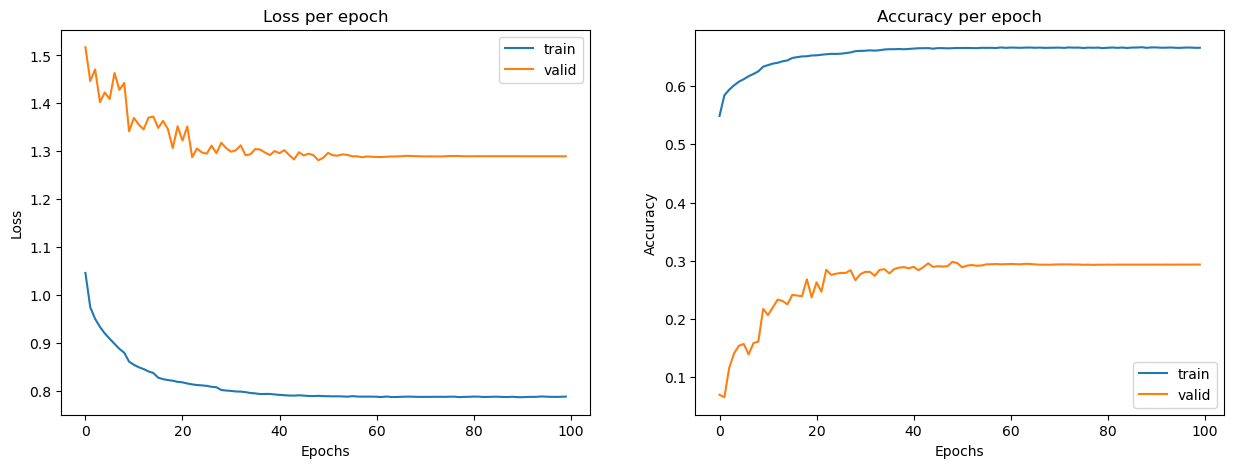

In [38]:
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label = 'train')
plt.plot(history1.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history1.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history1.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()

In [39]:
test_pred = model1.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))

print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 224us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.13      0.60      0.22      3050
           2       0.40      0.24      0.30     17500
           3       0.65      0.57      0.60     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.47    111784
weighted avg       0.63      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35296  1705  1479   7657
1                 209  1839   549    453
2                1722  5812  4257   5709
3               10783  4570  4252  25492



 Accuracy :  60.0


### Modèle 2 : recherche du meilleur loss

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 578.1724 - sparse_categorical_accuracy: 0.5033 - val_loss: 740.5986 - val_sparse_categorical_accuracy: 0.0606 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 502.8869 - sparse_categorical_accuracy: 0.5792 - val_loss: 746.3679 - val_sparse_categorical_accuracy: 0.1092 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 489.6068 - sparse_categorical_accuracy: 0.5912 - val_loss: 755.2762 - val_sparse_categorical_accuracy: 0.0694 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 482.2883 - sparse_categorical_accuracy: 0.5975 - val_loss: 759.3184 - val_sparse_categorical_accuracy: 0.1029 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 476.3108 - sparse_categorical_accuracy: 0.6022 - val_loss: 726.8901 - val_sparse_categorical_accuracy: 0.1373 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━

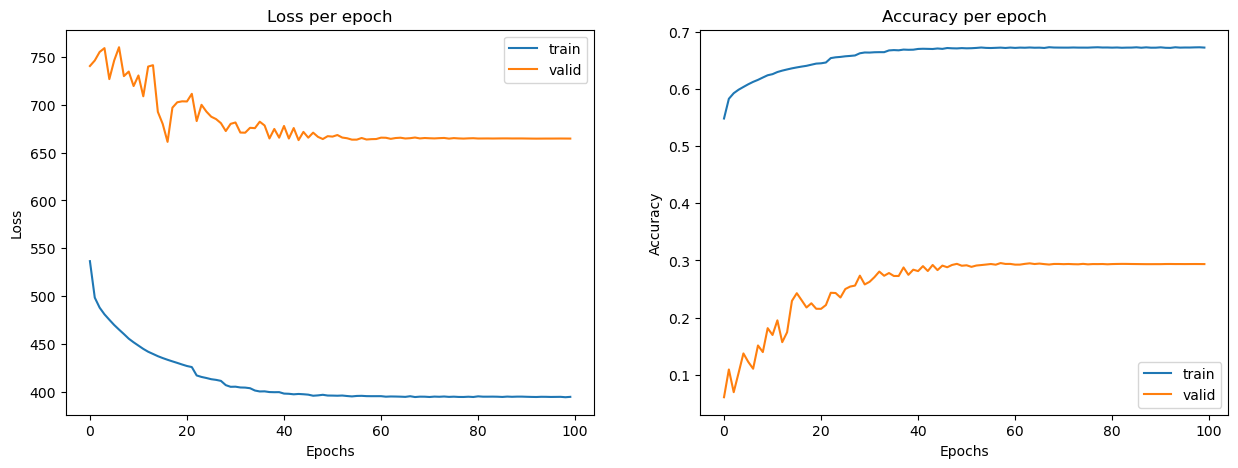

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.75     46137
           1       0.13      0.58      0.22      3050
           2       0.41      0.25      0.31     17500
           3       0.66      0.55      0.60     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.47    111784
weighted avg       0.63      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36288  1778  1384   6687
1                 219  1774   589    468
2                1872  5498  4290   5840
3               11806  4385  4220  24686



 Accuracy :  60.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1141 - sparse_categorical_accuracy: 0.5151 - val_loss: 1.4965 - val_sparse_categorical_accuracy: 0.0558 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9879 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.4455 - val_sparse_categorical_accuracy: 0.1165 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9600 - sparse_categorical_accuracy: 0.5901 - val_loss: 1.4275 - val_sparse_categorical_accuracy: 0.1252 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9423 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.4788 - val_sparse_categorical_accuracy: 0.1315 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9311 - sparse_categorical_accuracy: 0.6018 - val_loss: 1.4166 - val_sparse_categorical_accuracy: 0.1554 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

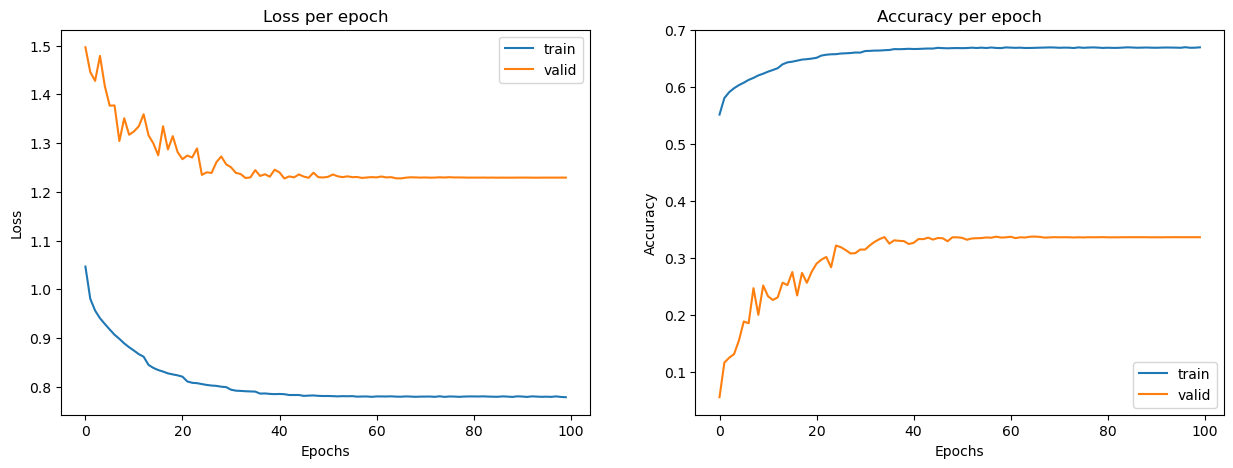

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.76     46137
           1       0.14      0.56      0.23      3050
           2       0.41      0.30      0.34     17500
           3       0.66      0.53      0.59     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.55      0.48    111784
weighted avg       0.63      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36669  1451  1560   6457
1                 250  1709   671    420
2                1904  5101  5181   5314
3               12057  3816  5229  23995



 Accuracy :  60.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1292 - sparse_categorical_accuracy: 0.5022 - val_loss: 1.4913 - val_sparse_categorical_accuracy: 0.0675 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9840 - sparse_categorical_accuracy: 0.5782 - val_loss: 1.4937 - val_sparse_categorical_accuracy: 0.0685 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9573 - sparse_categorical_accuracy: 0.5910 - val_loss: 1.4372 - val_sparse_categorical_accuracy: 0.1219 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9411 - sparse_categorical_accuracy: 0.5977 - val_loss: 1.4664 - val_sparse_categorical_accuracy: 0.1099 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9267 - sparse_categorical_accuracy: 0.6050 - val_loss: 1.4280 - val_sparse_categorical_accuracy: 0.1231 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

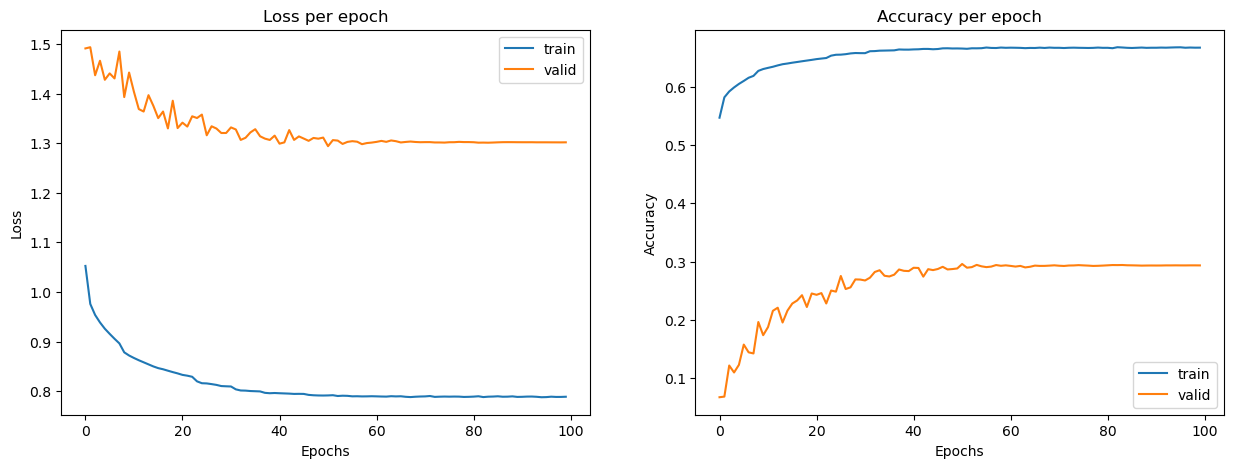

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     46137
           1       0.13      0.57      0.22      3050
           2       0.41      0.25      0.31     17500
           3       0.65      0.56      0.60     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.47    111784
weighted avg       0.63      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35735  1573  1516   7313
1                 244  1738   609    459
2                1795  5408  4384   5913
3               11247  4197  4231  25422



 Accuracy :  60.0


In [20]:
reductions = ["sum", "sum_over_batch_size", None]

for reduction in reductions :
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction = reduction,
        name="sparse_categorical_crossentropy",
    )

    model2 = Sequential()
    model2.add( Dense(units = 70, activation = 'relu', input_shape = (X_train.shape[1],)))
    model2.add(Dense(units = 140, activation = 'relu'))
    model2.add(Dropout(rate = 0.2))
    model2.add( Dense(units = 70, activation = 'relu'))
    model2.add(Dense(units = 35, activation = 'relu'))
    model2.add(Dropout(rate = 0.2))
    model2.add(Dense(units = 14, activation = 'relu'))
    model2.add(Dense(units = 4, activation = 'softmax'))
    
    model2.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history2 = model2.fit(X_train_ro, y_train_ro, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Loss avec reduction :", reduction)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history2.history['loss'], label = 'train')
    plt.plot(history2.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history2.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history2.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()

    test_pred = model2.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)
    
    

La meilleure reduction semble être "sum_over_batch_size"

### Modèle 3 : recherche de la meilleure activation

In [23]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

Epoch 1/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1118 - sparse_categorical_accuracy: 0.5127 - val_loss: 1.4027 - val_sparse_categorical_accuracy: 0.0949 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9839 - sparse_categorical_accuracy: 0.5796 - val_loss: 1.4100 - val_sparse_categorical_accuracy: 0.1274 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9605 - sparse_categorical_accuracy: 0.5885 - val_loss: 1.3937 - val_sparse_categorical_accuracy: 0.1216 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9434 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.4339 - val_sparse_categorical_accuracy: 0.1148 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9284 - sparse_categorical_accuracy: 0.6030 - val_loss: 1.4372 - val_sparse_categorical_accuracy: 0.1277 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3

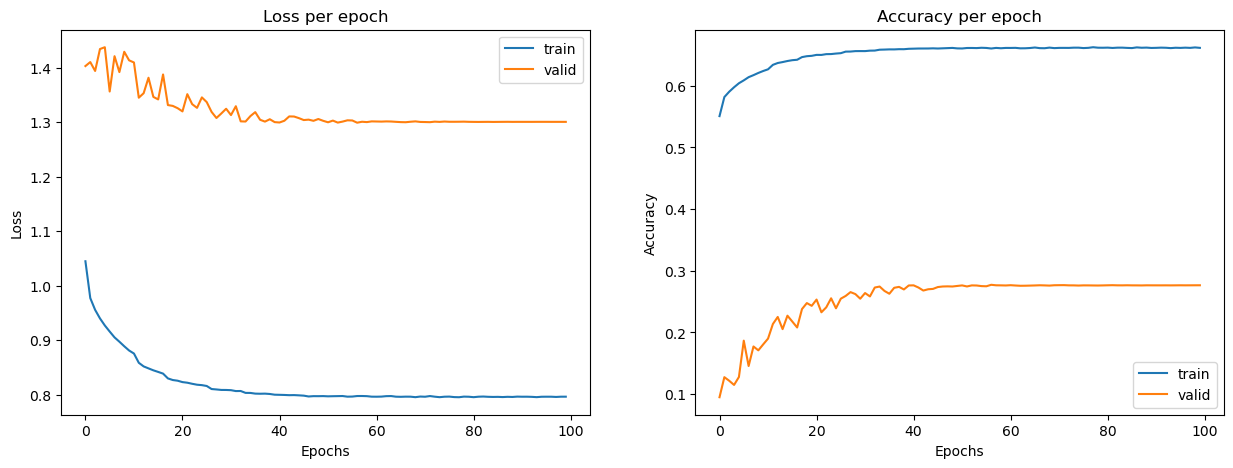

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     46137
           1       0.14      0.58      0.22      3050
           2       0.41      0.23      0.30     17500
           3       0.64      0.58      0.61     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.47    111784
weighted avg       0.63      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35415  1662  1450   7610
1                 225  1760   540    525
2                1731  5433  4097   6239
3               11040  4135  3839  26083



 Accuracy :  60.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2411 - sparse_categorical_accuracy: 0.4159 - val_loss: 1.4896 - val_sparse_categorical_accuracy: 0.0278 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0463 - sparse_categorical_accuracy: 0.5549 - val_loss: 1.5490 - val_sparse_categorical_accuracy: 0.0275 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0245 - sparse_categorical_accuracy: 0.5628 - val_loss: 1.5122 - val_sparse_categorical_accuracy: 0.0370 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0075 - sparse_categorical_accuracy: 0.5678 - val_loss: 1.5154 - val_sparse_categorical_accuracy: 0.0374 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9975 - sparse_categorical_accuracy: 0.5725 - val_loss: 1.5040 - val_sparse_categorical_accuracy: 0.0532 - learning_rate: 0.0010
Epoch 6/100
956/974 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

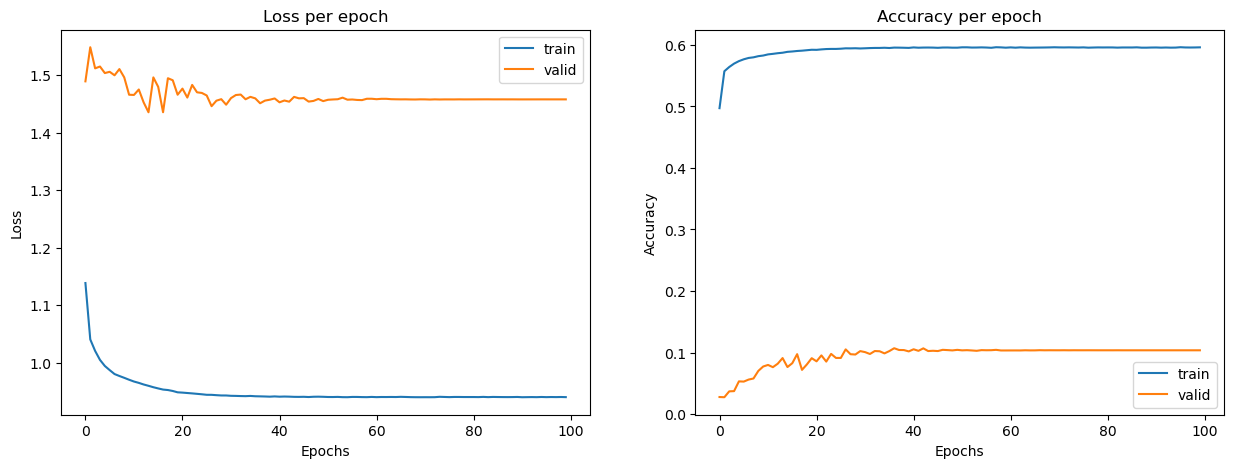

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step
              precision    recall  f1-score   support

           0       0.72      0.80      0.76     46137
           1       0.11      0.78      0.19      3050
           2       0.43      0.08      0.13     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.55      0.42    111784
weighted avg       0.64      0.58      0.58    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36901  3297   121   5818
1                 201  2372    95    382
2                1788  8760  1366   5586
3               12536  7262  1565  23734



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0998 - sparse_categorical_accuracy: 0.5166 - val_loss: 1.4318 - val_sparse_categorical_accuracy: 0.1259 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9962 - sparse_categorical_accuracy: 0.5718 - val_loss: 1.4395 - val_sparse_categorical_accuracy: 0.1366 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9670 - sparse_categorical_accuracy: 0.5856 - val_loss: 1.4529 - val_sparse_categorical_accuracy: 0.1355 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9544 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.4704 - val_sparse_categorical_accuracy: 0.1268 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9428 - sparse_categorical_accuracy: 0.5956 - val_loss: 1.4504 - val_sparse_categorical_accuracy: 0.1444 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

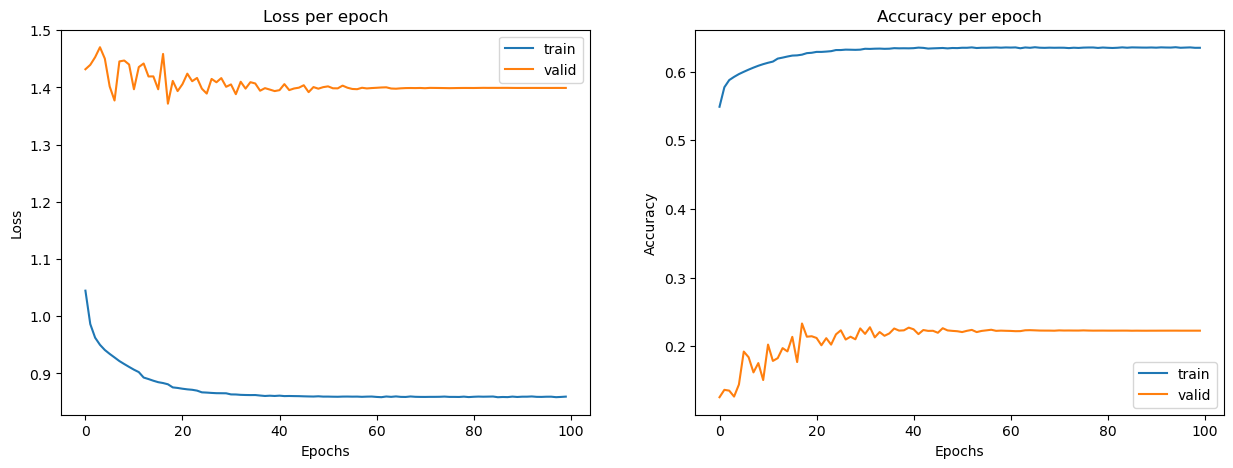

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.12      0.70      0.20      3050
           2       0.43      0.19      0.27     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36272  2873   936   6056
1                 192  2143   346    369
2                1677  7180  3400   5243
3               11617  6358  3157  23965



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1145 - sparse_categorical_accuracy: 0.5085 - val_loss: 1.5177 - val_sparse_categorical_accuracy: 0.0657 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9850 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.4439 - val_sparse_categorical_accuracy: 0.0700 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9607 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.4764 - val_sparse_categorical_accuracy: 0.0961 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9509 - sparse_categorical_accuracy: 0.5928 - val_loss: 1.4836 - val_sparse_categorical_accuracy: 0.1015 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9394 - sparse_categorical_accuracy: 0.5971 - val_loss: 1.3820 - val_sparse_categorical_accuracy: 0.1579 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

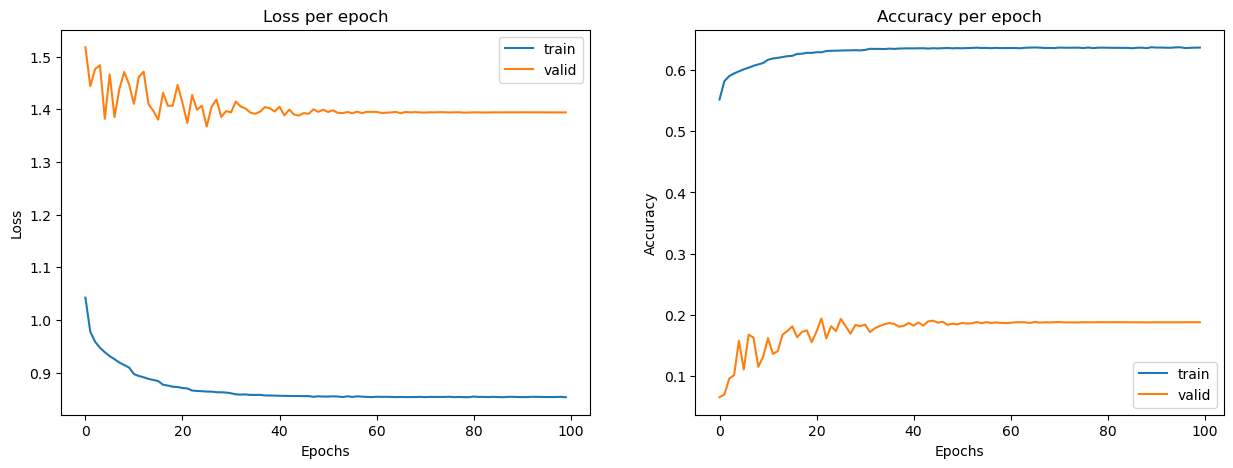

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.12      0.72      0.20      3050
           2       0.41      0.16      0.23     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.55      0.44    111784
weighted avg       0.64      0.58      0.59    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36476  2732   842   6087
1                 186  2195   278    391
2                1790  7568  2745   5397
3               11745  6573  2815  23964



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0950 - sparse_categorical_accuracy: 0.5260 - val_loss: 1.5278 - val_sparse_categorical_accuracy: 0.0614 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9839 - sparse_categorical_accuracy: 0.5781 - val_loss: 1.4522 - val_sparse_categorical_accuracy: 0.1110 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9611 - sparse_categorical_accuracy: 0.5877 - val_loss: 1.4630 - val_sparse_categorical_accuracy: 0.1019 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9460 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.4365 - val_sparse_categorical_accuracy: 0.1361 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9359 - sparse_categorical_accuracy: 0.5987 - val_loss: 1.4042 - val_sparse_categorical_accuracy: 0.1776 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

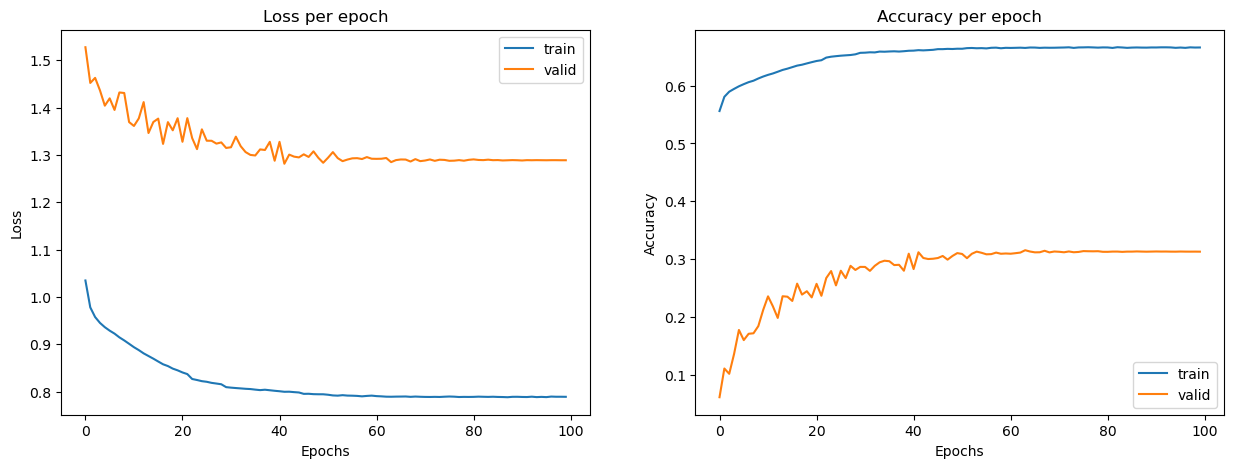

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.13      0.63      0.21      3050
           2       0.42      0.27      0.33     17500
           3       0.67      0.54      0.59     45097

    accuracy                           0.60    111784
   macro avg       0.49      0.56      0.47    111784
weighted avg       0.64      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36023  2156  1382   6576
1                 200  1926   536    388
2                1750  5910  4787   5053
3               11368  4946  4606  24177



 Accuracy :  60.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0982 - sparse_categorical_accuracy: 0.5226 - val_loss: 1.4430 - val_sparse_categorical_accuracy: 0.1013 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9988 - sparse_categorical_accuracy: 0.5726 - val_loss: 1.4056 - val_sparse_categorical_accuracy: 0.1234 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9811 - sparse_categorical_accuracy: 0.5793 - val_loss: 1.4318 - val_sparse_categorical_accuracy: 0.1160 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9659 - sparse_categorical_accuracy: 0.5861 - val_loss: 1.4287 - val_sparse_categorical_accuracy: 0.1376 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9530 - sparse_categorical_accuracy: 0.5915 - val_loss: 1.4526 - val_sparse_categorical_accuracy: 0.1371 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

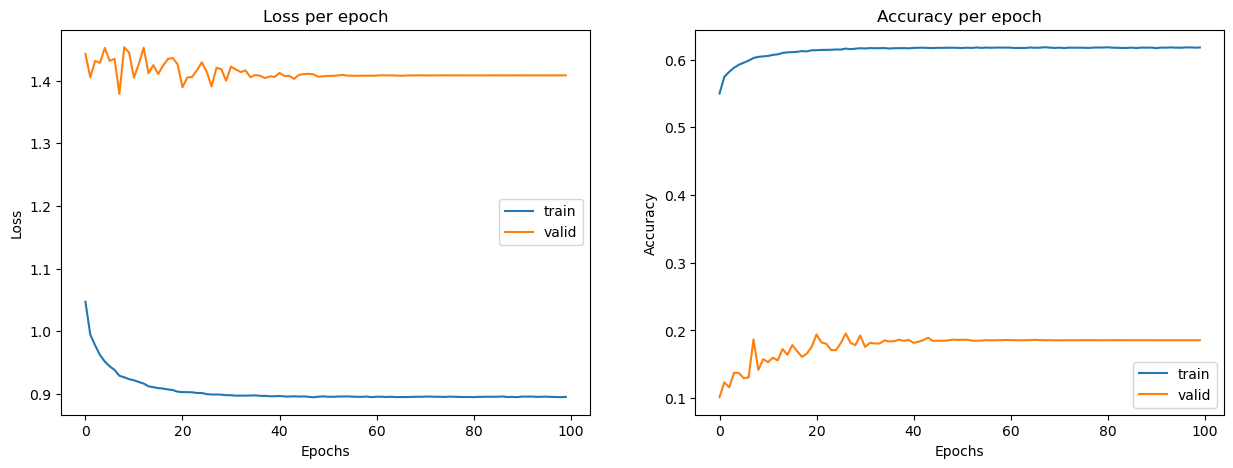

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.11      0.76      0.20      3050
           2       0.42      0.16      0.23     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.58    111784
   macro avg       0.48      0.56      0.44    111784
weighted avg       0.64      0.58      0.59    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36031  3037   722   6347
1                 172  2304   219    355
2                1549  8111  2749   5091
3               11197  7010  2877  24013



 Accuracy :  57.99999999999999
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.1873 - sparse_categorical_accuracy: 0.4945 - val_loss: 1.4926 - val_sparse_categorical_accuracy: 0.0536 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0096 - sparse_categorical_accuracy: 0.5681 - val_loss: 1.4166 - val_sparse_categorical_accuracy: 0.1268 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9894 - sparse_categorical_accuracy: 0.5768 - val_loss: 1.5278 - val_sparse_categorical_accuracy: 0.0784 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9722 - sparse_categorical_accuracy: 0.5826 - val_loss: 1.4198 - val_sparse_categorical_accuracy: 0.1321 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9610 - sparse_categorical_accuracy: 0.5878 - val_loss: 1.4530 - val_sparse_categorical_accuracy: 0.1066 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lo

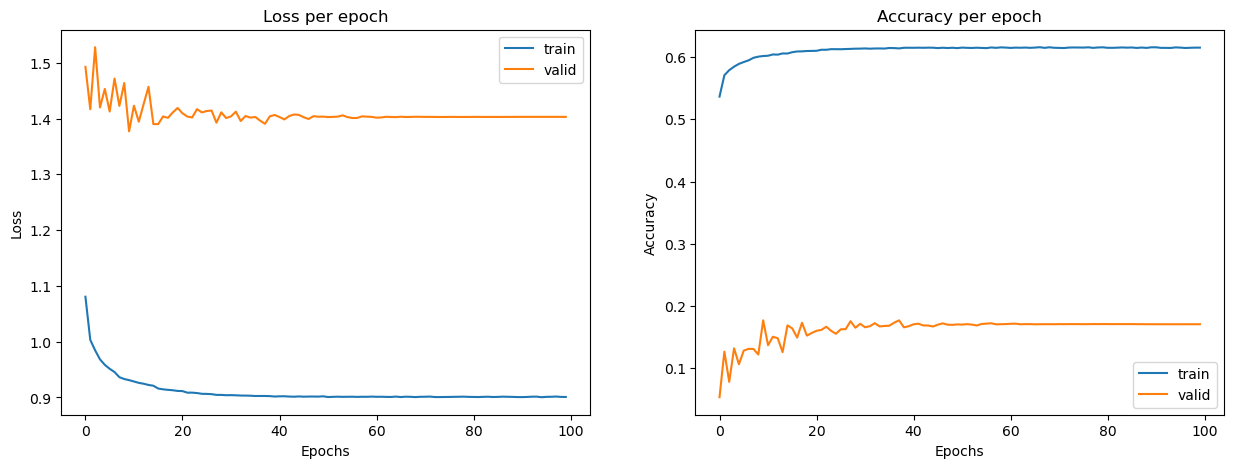

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step
              precision    recall  f1-score   support

           0       0.74      0.78      0.76     46137
           1       0.11      0.75      0.20      3050
           2       0.43      0.15      0.22     17500
           3       0.67      0.55      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.56      0.44    111784
weighted avg       0.64      0.59      0.59    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35866  2935   660   6676
1                 179  2289   215    367
2                1617  8021  2560   5302
3               11009  6917  2458  24713



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0913 - sparse_categorical_accuracy: 0.5268 - val_loss: 1.4779 - val_sparse_categorical_accuracy: 0.0814 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9732 - sparse_categorical_accuracy: 0.5842 - val_loss: 1.4278 - val_sparse_categorical_accuracy: 0.1301 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9489 - sparse_categorical_accuracy: 0.5932 - val_loss: 1.4865 - val_sparse_categorical_accuracy: 0.1238 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9350 - sparse_categorical_accuracy: 0.6002 - val_loss: 1.4808 - val_sparse_categorical_accuracy: 0.1311 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9236 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.4896 - val_sparse_categorical_accuracy: 0.1315 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

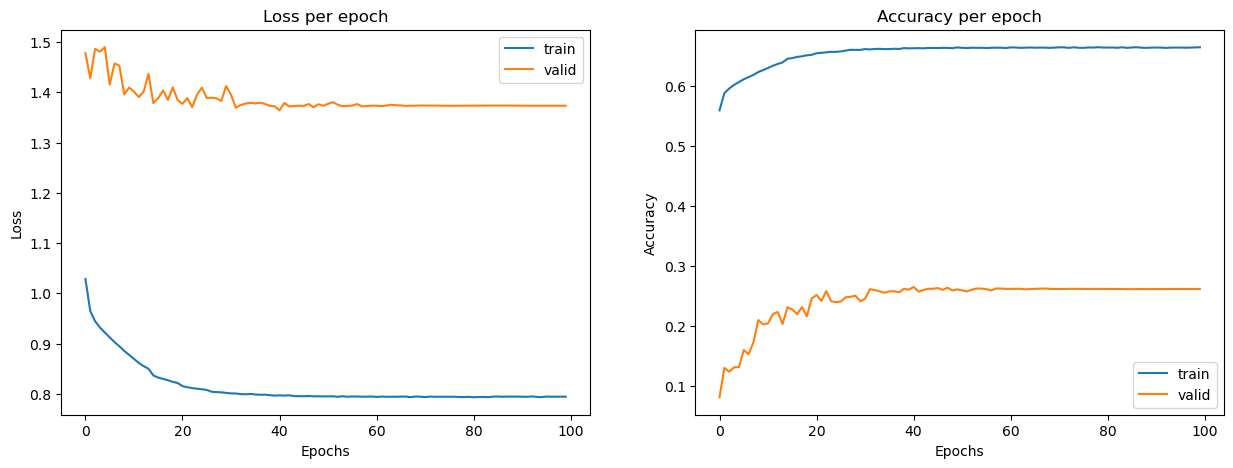

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.76     46137
           1       0.12      0.64      0.20      3050
           2       0.42      0.22      0.29     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.46    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36622  2411  1193   5911
1                 212  1962   458    418
2                1817  6478  3931   5274
3               11919  5658  3835  23685



 Accuracy :  59.0


In [24]:
activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu', 'swish', 'elu', 'selu', 'gelu']

for activation in activations :
    model3 = Sequential()
    model3.add( Dense(units = 70, activation = activation, input_shape = (X_train.shape[1],)))
    model3.add(Dense(units = 140, activation = activation))
    model3.add(Dropout(rate = 0.2))
    model3.add( Dense(units = 70, activation = activation))
    model3.add(Dense(units = 35, activation = activation))
    model3.add(Dropout(rate = 0.2))
    model3.add(Dense(units = 14, activation = activation))
    model3.add(Dense(units = 4, activation = 'softmax'))

    model3.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history3 = model3.fit(X_train_ro, y_train_ro, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec activation :", activation)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history3.history['loss'], label = 'train')
    plt.plot(history3.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history3.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history3.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model3.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

La meilleure activation est swich par rapport aux résultats et aux F1 score des blessés légers.

### Modèle 4 : ajout de kernel_initializer

In [25]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1183.5566 - sparse_categorical_accuracy: 0.2657 - val_loss: 1.7927 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7274 - sparse_categorical_accuracy: 0.2791 - val_loss: 1.9250 - val_sparse_categorical_accuracy: 0.0396 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.1798 - sparse_categorical_accuracy: 0.2783 - val_loss: 1.7079 - val_sparse_categorical_accuracy: 0.0112 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7992 - sparse_categorical_accuracy: 0.2812 - val_loss: 1.7601 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6428 - sparse_categorical_accuracy: 0.2804 - val_loss: 1.7467 - val_sparse_categorical_accuracy: 0.0079 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3m

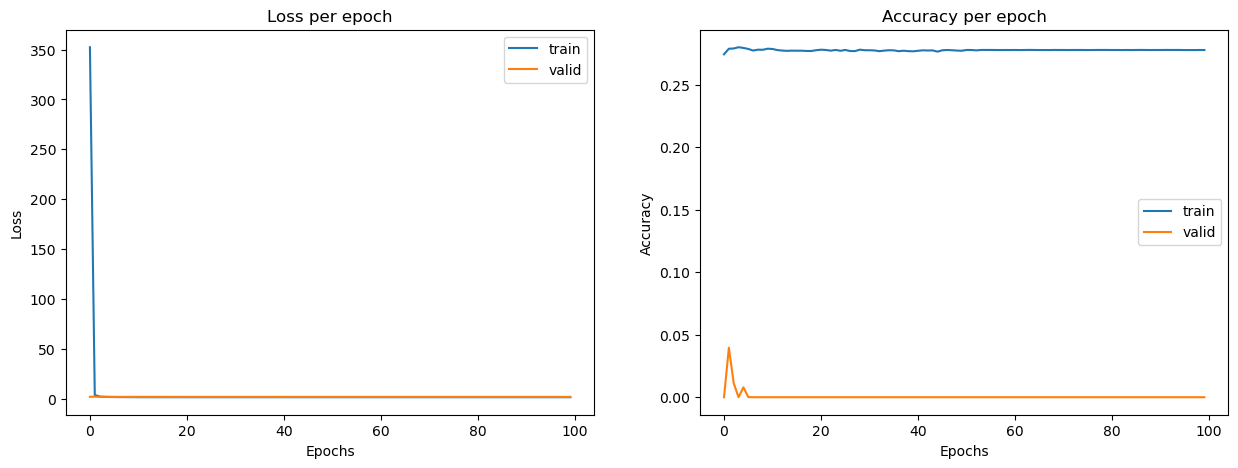

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     46137
           1       0.00      0.00      0.00      3050
           2       0.00      0.00      0.00     17500
           3       0.00      0.00      0.00     45097

    accuracy                           0.41    111784
   macro avg       0.10      0.25      0.15    111784
weighted avg       0.17      0.41      0.24    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite      0
Classe réelle        
0               46137
1                3050
2               17500
3               45097



 Accuracy :  41.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4562365.5000 - sparse_categorical_accuracy: 0.2633 - val_loss: 69991.6406 - val_sparse_categorical_accuracy: 0.0563 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 67399.8047 - sparse_categorical_accuracy: 0.2574 - val_loss: 31523.8008 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 15604.1221 - sparse_categorical_accuracy: 0.2585 - val_loss: 79612.1719 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10817.1787 - sparse_categorical_accuracy: 0.2580 - val_loss: 22492.0664 - val_sparse_categorical_accuracy: 0.0562 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7847.4731 - sparse_categorical_accuracy: 0.2570 - val_loss: 18435.5977 - val_sparse_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0010
Epoc

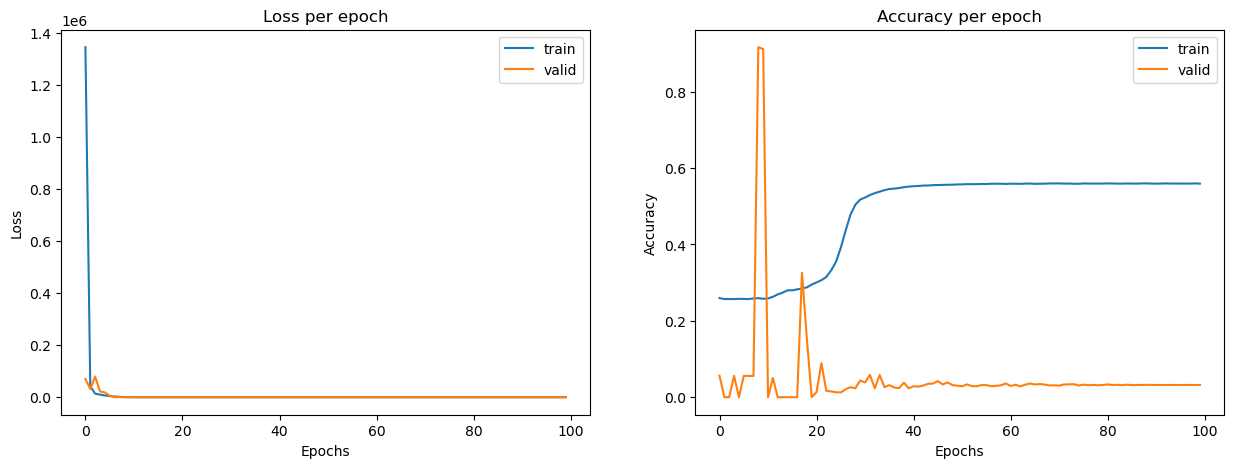

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step
              precision    recall  f1-score   support

           0       0.69      0.76      0.73     46137
           1       0.09      0.81      0.16      3050
           2       0.41      0.01      0.01     17500
           3       0.65      0.46      0.54     45097

    accuracy                           0.52    111784
   macro avg       0.46      0.51      0.36    111784
weighted avg       0.61      0.52      0.52    111784
 




Classe prédite      0      1    2      3
Classe réelle                           
0               35175   5242   18   5702
1                 233   2459   12    346
2                1868  10316  124   5192
3               13549  10559  148  20841



 Accuracy :  52.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 789.6096 - sparse_categorical_accuracy: 0.2703 - val_loss: 1.7849 - val_sparse_categorical_accuracy: 5.4186e-05 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6255 - sparse_categorical_accuracy: 0.2802 - val_loss: 1.7324 - val_sparse_categorical_accuracy: 1.8062e-05 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6131 - sparse_categorical_accuracy: 0.2791 - val_loss: 1.7373 - val_sparse_categorical_accuracy: 1.4450e-04 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5042 - sparse_categorical_accuracy: 0.2791 - val_loss: 1.7399 - val_sparse_categorical_accuracy: 5.7798e-04 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4763 - sparse_categorical_accuracy: 0.2804 - val_loss: 1.7351 - val_sparse_categorical_accuracy: 9.7535e-04 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━

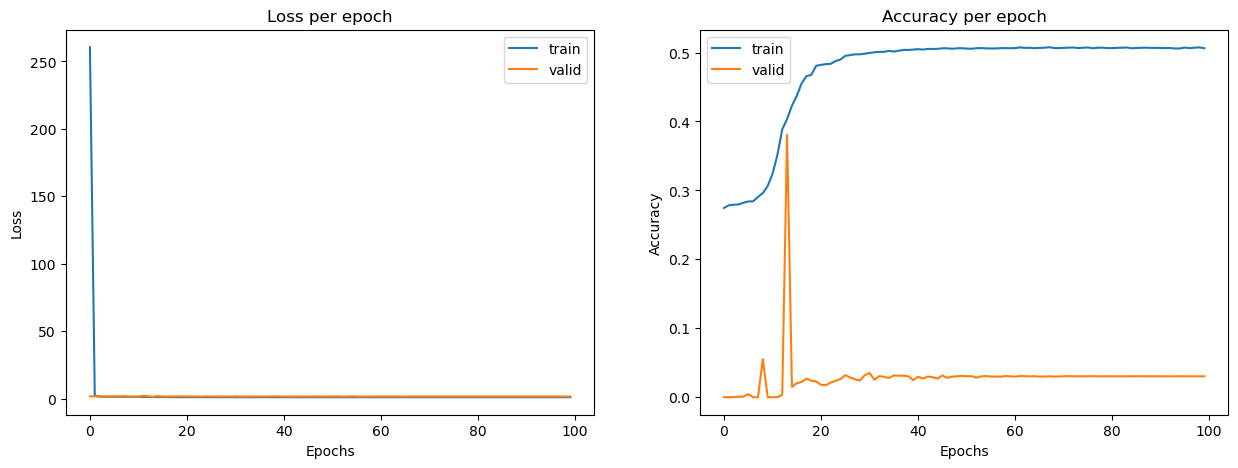

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
              precision    recall  f1-score   support

           0       0.67      0.76      0.71     46137
           1       0.11      0.58      0.19      3050
           2       0.00      0.00      0.00     17500
           3       0.55      0.54      0.55     45097

    accuracy                           0.55    111784
   macro avg       0.33      0.47      0.36    111784
weighted avg       0.50      0.55      0.52    111784
 




/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Classe prédite      0     1      3
Classe réelle                     
0               34858  2244   9035
1                 171  1762   1117
2                1717  6313   9470
3               15395  5232  24470



 Accuracy :  55.00000000000001
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.4874 - val_sparse_categorical_accuracy: 0.0933 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9860 - sparse_categorical_accuracy: 0.5783 - val_loss: 1.5118 - val_sparse_categorical_accuracy: 0.0922 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9671 - sparse_categorical_accuracy: 0.5854 - val_loss: 1.4313 - val_sparse_categorical_accuracy: 0.1585 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9525 - sparse_categorical_accuracy: 0.5909 - val_loss: 1.4634 - val_sparse_categorical_accuracy: 0.1097 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9369 - sparse_categorical_accuracy: 0.5983 - val_loss: 1.4694 - val_sparse_categorical_accuracy: 0.1248 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

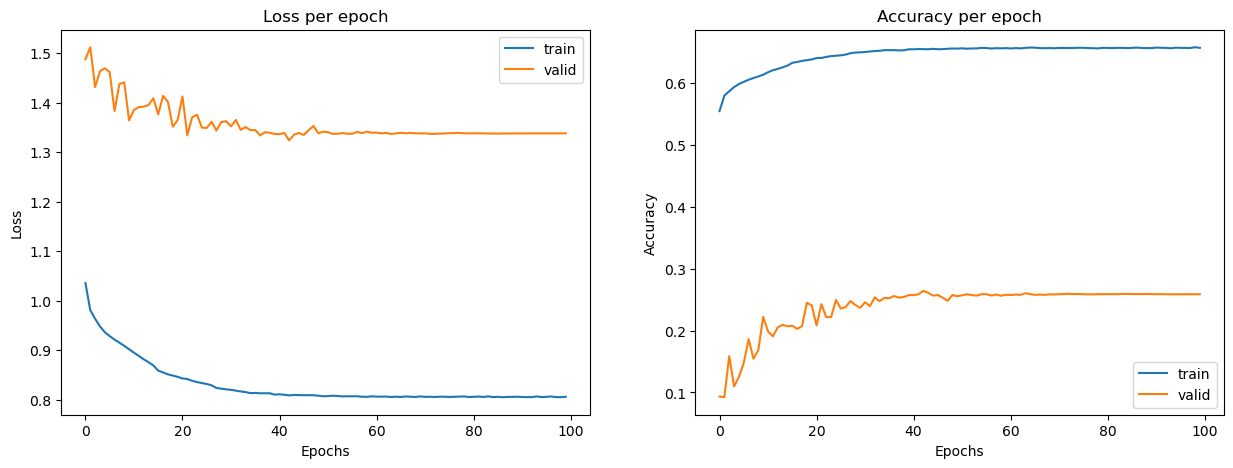

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.12      0.65      0.20      3050
           2       0.42      0.22      0.29     17500
           3       0.67      0.55      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.46    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35913  2348  1217   6659
1                 206  1982   462    400
2                1711  6606  3911   5272
3               11185  5486  3783  24643



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0952 - sparse_categorical_accuracy: 0.5236 - val_loss: 1.4219 - val_sparse_categorical_accuracy: 0.1152 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9864 - sparse_categorical_accuracy: 0.5772 - val_loss: 1.4910 - val_sparse_categorical_accuracy: 0.1032 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9662 - sparse_categorical_accuracy: 0.5858 - val_loss: 1.4435 - val_sparse_categorical_accuracy: 0.1406 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9519 - sparse_categorical_accuracy: 0.5910 - val_loss: 1.4815 - val_sparse_categorical_accuracy: 0.1138 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9386 - sparse_categorical_accuracy: 0.5979 - val_loss: 1.4716 - val_sparse_categorical_accuracy: 0.1230 - learning_rate: 0.0010
Epoch 6/100
973/974 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

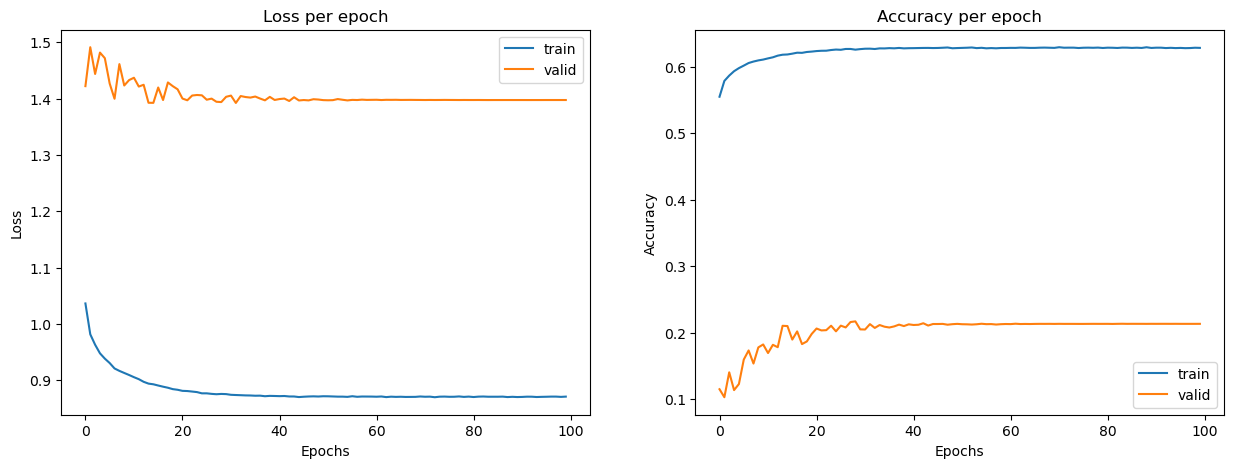

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.12      0.72      0.20      3050
           2       0.42      0.18      0.25     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36468  2705   884   6080
1                 205  2188   300    357
2                1768  7295  3136   5301
3               11765  6286  3093  23953



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 991s 3ms/step - loss: 1.1538 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.4461 - val_sparse_categorical_accuracy: 0.0752 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 225s 3ms/step - loss: 0.9850 - sparse_categorical_accuracy: 0.5772 - val_loss: 1.4398 - val_sparse_categorical_accuracy: 0.1101 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9558 - sparse_categorical_accuracy: 0.5914 - val_loss: 1.4424 - val_sparse_categorical_accuracy: 0.1335 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9410 - sparse_categorical_accuracy: 0.5972 - val_loss: 1.3872 - val_sparse_categorical_accuracy: 0.1799 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9292 - sparse_categorical_accuracy: 0.6033 - val_loss: 1.4685 - val_sparse_categorical_accuracy: 0.1259 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step 

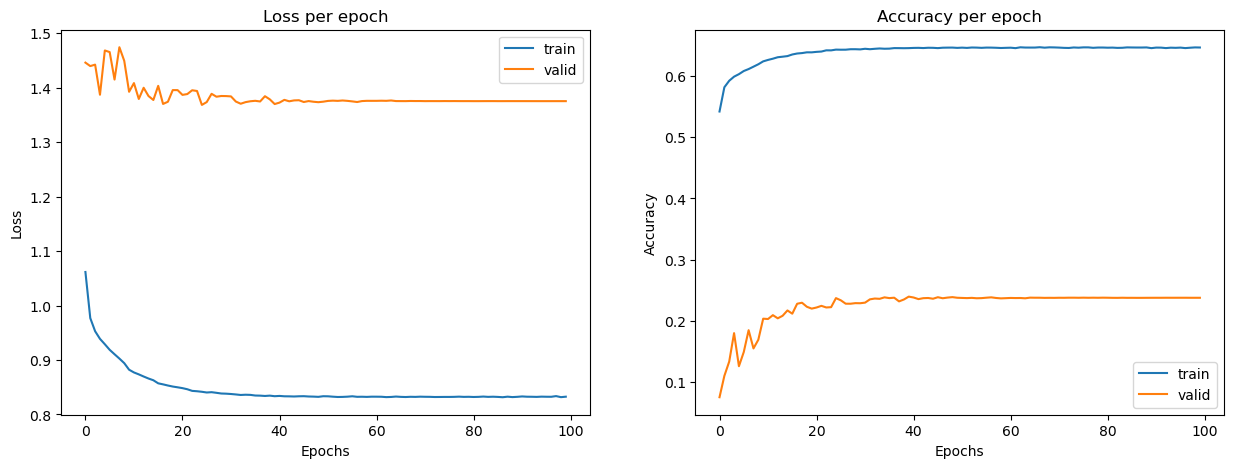

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     46137
           1       0.12      0.68      0.20      3050
           2       0.41      0.21      0.27     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36191  2734  1109   6103
1                 198  2080   404    368
2                1710  7091  3589   5110
3               11492  6168  3692  23745



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1557 - sparse_categorical_accuracy: 0.4947 - val_loss: 1.5362 - val_sparse_categorical_accuracy: 0.0656 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9886 - sparse_categorical_accuracy: 0.5765 - val_loss: 1.4660 - val_sparse_categorical_accuracy: 0.1128 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9576 - sparse_categorical_accuracy: 0.5898 - val_loss: 1.4083 - val_sparse_categorical_accuracy: 0.1434 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9451 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.4673 - val_sparse_categorical_accuracy: 0.1358 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9319 - sparse_categorical_accuracy: 0.6018 - val_loss: 1.4563 - val_sparse_categorical_accuracy: 0.1362 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

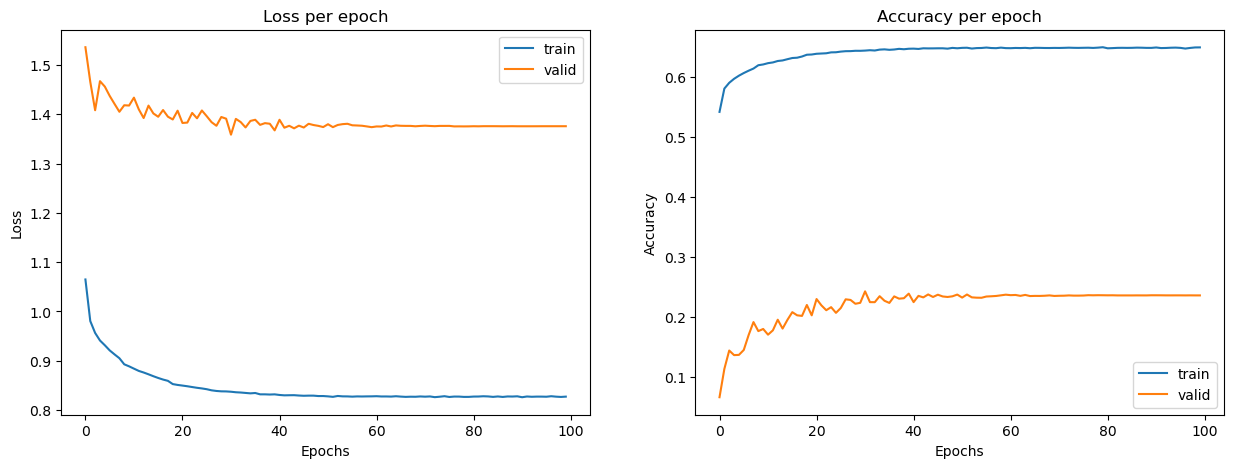

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 279us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     46137
           1       0.12      0.68      0.20      3050
           2       0.41      0.19      0.26     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36163  2472  1104   6398
1                 191  2085   381    393
2                1715  7054  3380   5351
3               11538  5899  3396  24264



 Accuracy :  59.0


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0979 - sparse_categorical_accuracy: 0.5209 - val_loss: 1.4634 - val_sparse_categorical_accuracy: 0.0942 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9863 - sparse_categorical_accuracy: 0.5780 - val_loss: 1.4685 - val_sparse_categorical_accuracy: 0.1115 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - loss: 0.9661 - sparse_categorical_accuracy: 0.5865 - val_loss: 1.4571 - val_sparse_categorical_accuracy: 0.1138 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9500 - sparse_categorical_accuracy: 0.5928 - val_loss: 1.4618 - val_sparse_categorical_accuracy: 0.1300 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 912s 937ms/step - loss: 0.9417 - sparse_categorical_accuracy: 0.5961 - val_loss: 1.3747 - val_sparse_categorical_accuracy: 0.1928 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━

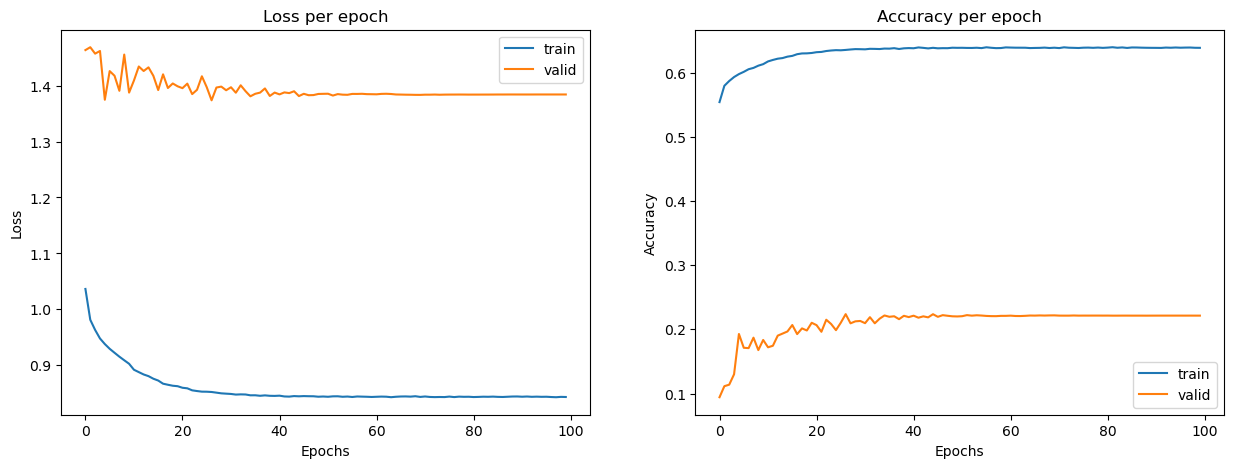

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     46137
           1       0.12      0.72      0.20      3050
           2       0.42      0.19      0.26     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.56      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35973  2821   908   6435
1                 176  2195   308    371
2                1635  7486  3337   5042
3               11220  6388  3400  24089



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5208 - val_loss: 1.4514 - val_sparse_categorical_accuracy: 0.1045 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9844 - sparse_categorical_accuracy: 0.5768 - val_loss: 1.4508 - val_sparse_categorical_accuracy: 0.1227 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9607 - sparse_categorical_accuracy: 0.5877 - val_loss: 1.4959 - val_sparse_categorical_accuracy: 0.1240 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9433 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.4288 - val_sparse_categorical_accuracy: 0.1370 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9343 - sparse_categorical_accuracy: 0.5980 - val_loss: 1.4550 - val_sparse_categorical_accuracy: 0.1584 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

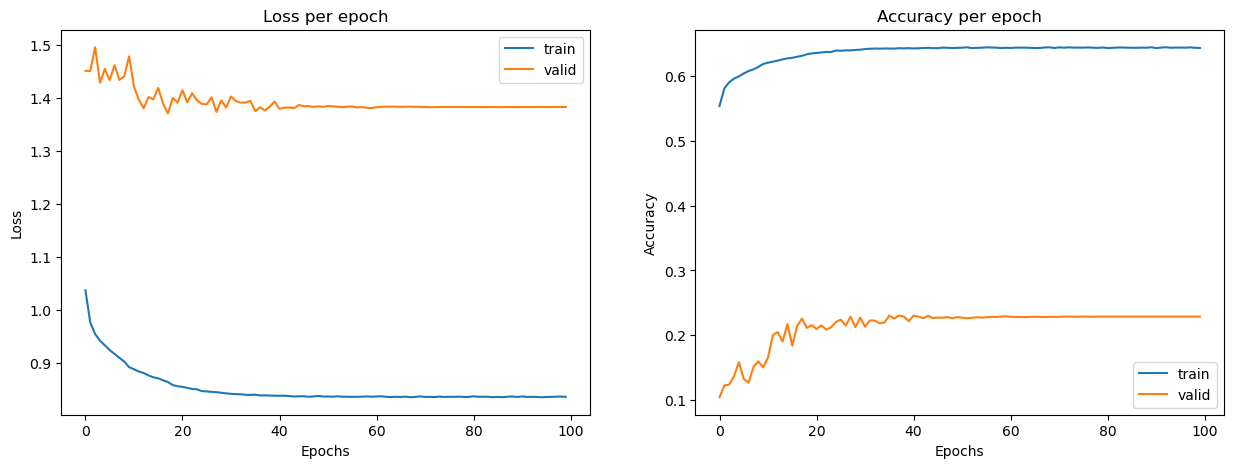

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.12      0.70      0.20      3050
           2       0.41      0.19      0.26     17500
           3       0.67      0.52      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36570  2633   992   5942
1                 194  2144   352    360
2                1737  7269  3407   5087
3               11819  6195  3512  23571



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.5171 - val_loss: 1.4356 - val_sparse_categorical_accuracy: 0.0944 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9894 - sparse_categorical_accuracy: 0.5766 - val_loss: 1.4361 - val_sparse_categorical_accuracy: 0.1129 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9655 - sparse_categorical_accuracy: 0.5862 - val_loss: 1.4285 - val_sparse_categorical_accuracy: 0.1275 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9473 - sparse_categorical_accuracy: 0.5924 - val_loss: 1.3914 - val_sparse_categorical_accuracy: 0.1591 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9401 - sparse_categorical_accuracy: 0.5963 - val_loss: 1.5098 - val_sparse_categorical_accuracy: 0.1002 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

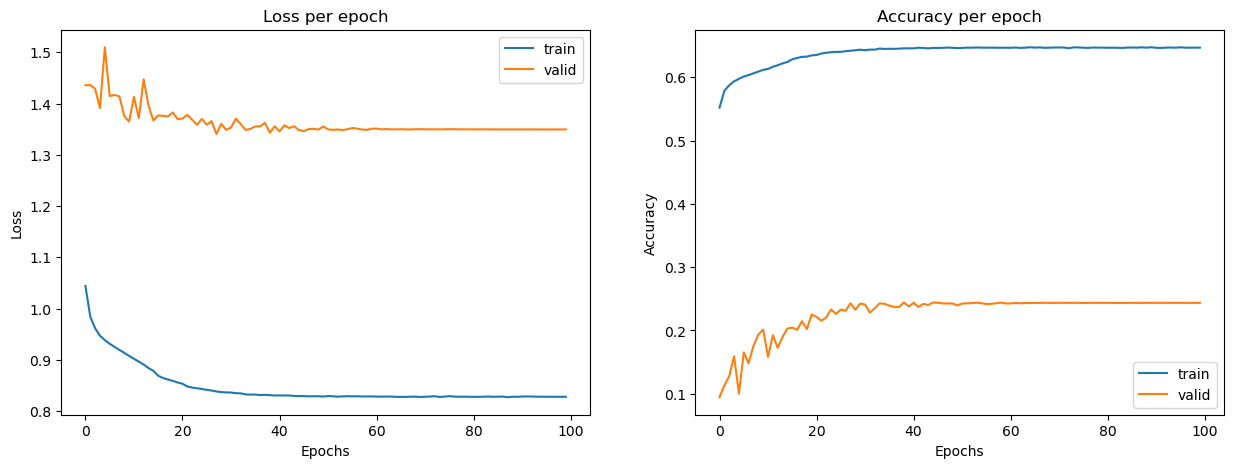

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 279us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.12      0.69      0.20      3050
           2       0.42      0.21      0.28     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.46    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35659  2650  1072   6756
1                 179  2104   385    382
2                1642  7081  3600   5177
3               10992  6100  3528  24477



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1037 - sparse_categorical_accuracy: 0.5176 - val_loss: 1.4495 - val_sparse_categorical_accuracy: 0.1001 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9797 - sparse_categorical_accuracy: 0.5804 - val_loss: 1.4395 - val_sparse_categorical_accuracy: 0.1345 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9516 - sparse_categorical_accuracy: 0.5917 - val_loss: 1.4704 - val_sparse_categorical_accuracy: 0.1158 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9411 - sparse_categorical_accuracy: 0.5965 - val_loss: 1.4239 - val_sparse_categorical_accuracy: 0.1591 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9312 - sparse_categorical_accuracy: 0.5998 - val_loss: 1.4201 - val_sparse_categorical_accuracy: 0.1545 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

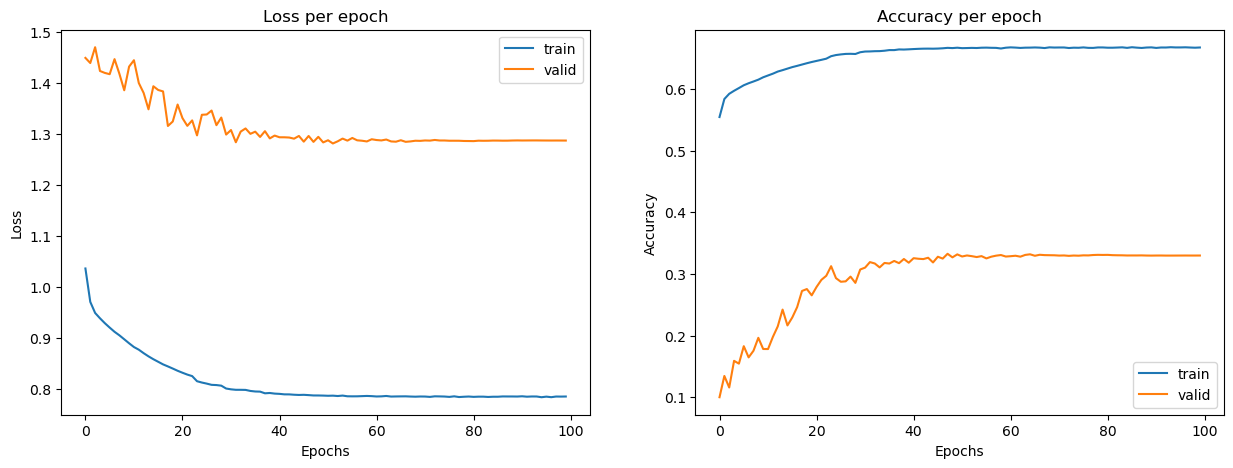

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 276us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.13      0.60      0.22      3050
           2       0.43      0.28      0.34     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.55      0.48    111784
weighted avg       0.64      0.61      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36320  1861  1412   6544
1                 214  1839   612    385
2                1776  5580  4973   5171
3               11564  4363  4663  24507



 Accuracy :  61.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1007 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.4802 - val_sparse_categorical_accuracy: 0.0749 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9818 - sparse_categorical_accuracy: 0.5786 - val_loss: 1.4324 - val_sparse_categorical_accuracy: 0.1082 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9572 - sparse_categorical_accuracy: 0.5895 - val_loss: 1.4958 - val_sparse_categorical_accuracy: 0.1118 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9465 - sparse_categorical_accuracy: 0.5938 - val_loss: 1.4567 - val_sparse_categorical_accuracy: 0.1228 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9356 - sparse_categorical_accuracy: 0.5989 - val_loss: 1.4026 - val_sparse_categorical_accuracy: 0.1682 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

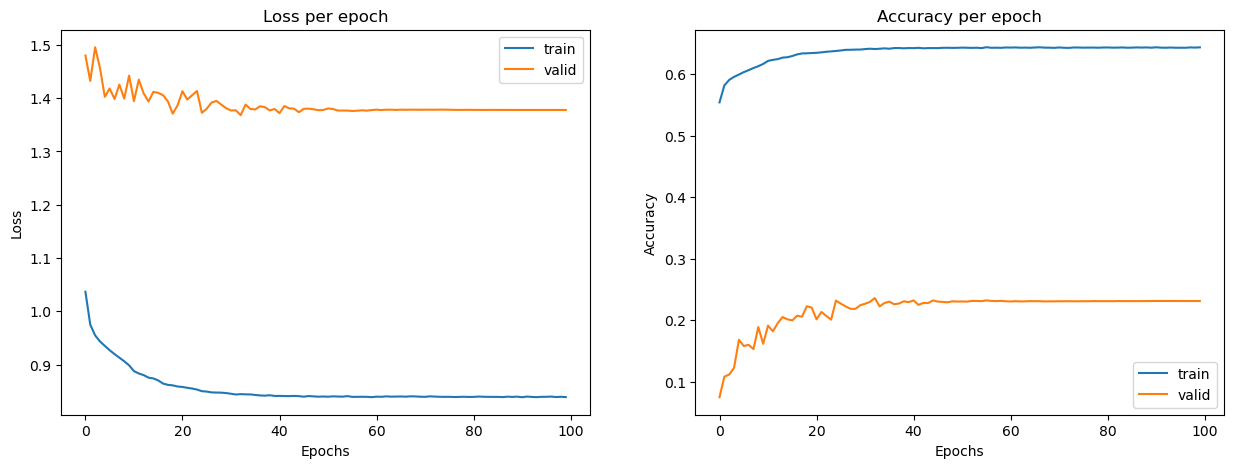

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.12      0.70      0.20      3050
           2       0.41      0.20      0.27     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36414  2736  1025   5962
1                 179  2124   353    394
2                1639  7123  3451   5287
3               11626  6138  3505  23828



 Accuracy :  59.0


In [26]:
RandomNormal = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
RandomUniform = tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0)
TruncatedNormal = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
GlorotNormal = tf.keras.initializers.GlorotNormal()
GlorotUniform = tf.keras.initializers.GlorotUniform()
HeNormal = tf.keras.initializers.HeNormal()
HeUniform = tf.keras.initializers.HeUniform()
Orthogonal = tf.keras.initializers.Orthogonal()
VarianceScaling_in = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_in", distribution="truncated_normal")
VarianceScaling_out = tf.keras.initializers.VarianceScaling(scale=1.0, mode="fan_out", distribution="truncated_normal")
LecunNormal = tf.keras.initializers.LecunNormal()
LecunUniform = tf.keras.initializers.LecunUniform()

kernel_initializers = [RandomNormal, 
                       RandomUniform, 
                       TruncatedNormal,
                       GlorotNormal,
                       GlorotUniform,
                       HeNormal,
                       HeUniform,
                       Orthogonal, 
                       VarianceScaling_in, 
                       VarianceScaling_out, 
                       LecunNormal, 
                       LecunUniform]

for kernel_initializer in kernel_initializers :
    model4 = Sequential()
    model4.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model4.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dropout(rate = 0.2))
    model4.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dropout(rate = 0.2))
    model4.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
    model4.add(Dense(units = 4, activation = 'softmax'))

    model4.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history4 = model4.fit(X_train_ro, y_train_ro, epochs = 100, batch_size = 512, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec kernel_initializer :", kernel_initializer)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history4.history['loss'], label = 'train')
    plt.plot(history4.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history4.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history4.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model4.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Le meilleur kernel_initializer est LecunNormal.

### Modèle 5 : choix du nombre de batch

In [28]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.LecunNormal()

Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 563us/step - loss: 1.0330 - sparse_categorical_accuracy: 0.5554 - val_loss: 1.4522 - val_sparse_categorical_accuracy: 0.1221 - learning_rate: 0.0010
Epoch 2/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 543us/step - loss: 0.9442 - sparse_categorical_accuracy: 0.5961 - val_loss: 1.4524 - val_sparse_categorical_accuracy: 0.1422 - learning_rate: 0.0010
Epoch 3/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 542us/step - loss: 0.9219 - sparse_categorical_accuracy: 0.6076 - val_loss: 1.4794 - val_sparse_categorical_accuracy: 0.1645 - learning_rate: 0.0010
Epoch 4/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 543us/step - loss: 0.9012 - sparse_categorical_accuracy: 0.6167 - val_loss: 1.3783 - val_sparse_categorical_accuracy: 0.2090 - learning_rate: 0.0010
Epoch 5/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 553us/step - loss: 0.8859 - sparse_categorical_accuracy: 0.6232 - val_loss: 1.3965 - val_sparse_categorical_accuracy: 0.2067 - learning_rate: 0.0010
Epoch 6/100
15572/15572 ━━━

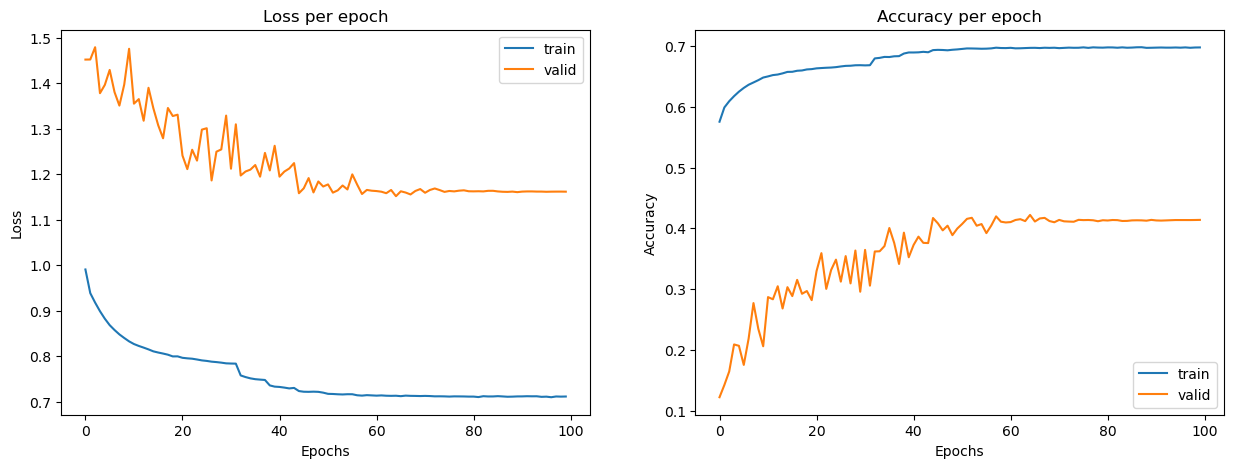

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step
              precision    recall  f1-score   support

           0       0.74      0.77      0.75     46137
           1       0.14      0.51      0.22      3050
           2       0.41      0.36      0.38     17500
           3       0.66      0.55      0.60     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.55      0.49    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35348  1517  2122   7150
1                 190  1549   876    435
2                1586  4522  6319   5073
3               10847  3523  6049  24678



 Accuracy :  61.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7786/7786 ━━━━━━━━━━━━━━━━━━━━ 301s 664us/step - loss: 1.0436 - sparse_categorical_accuracy: 0.5484 - val_loss: 1.4724 - val_sparse_categorical_accuracy: 0.1048 - learning_rate: 0.0010
Epoch 2/100
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 5s 642us/step - loss: 0.9530 - sparse_categorical_accuracy: 0.5920 - val_loss: 1.4198 - val_sparse_categorical_accuracy: 0.1749 - learning_rate: 0.0010
Epoch 3/100
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step - loss: 0.9294 - sparse_categorical_accuracy: 0.6024 - val_loss: 1.4849 - val_sparse_categorical_accuracy: 0.1538 - learning_rate: 0.0010
Epoch 4/100
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step - loss: 0.9113 - sparse_categorical_accuracy: 0.6108 - val_loss: 1.4042 - val_sparse_categorical_accuracy: 0.1904 - learning_rate: 0.0010
Epoch 5/100
7786/7786 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step - loss: 0.8954 - sparse_categorical_accuracy: 0.6185 - val_loss: 1.3694 - val_sparse_categorical_accuracy: 0.2036 - learning_rate: 0.0010
Epoch 6/100
7786/7786 ━━━━━━━━━━━━━

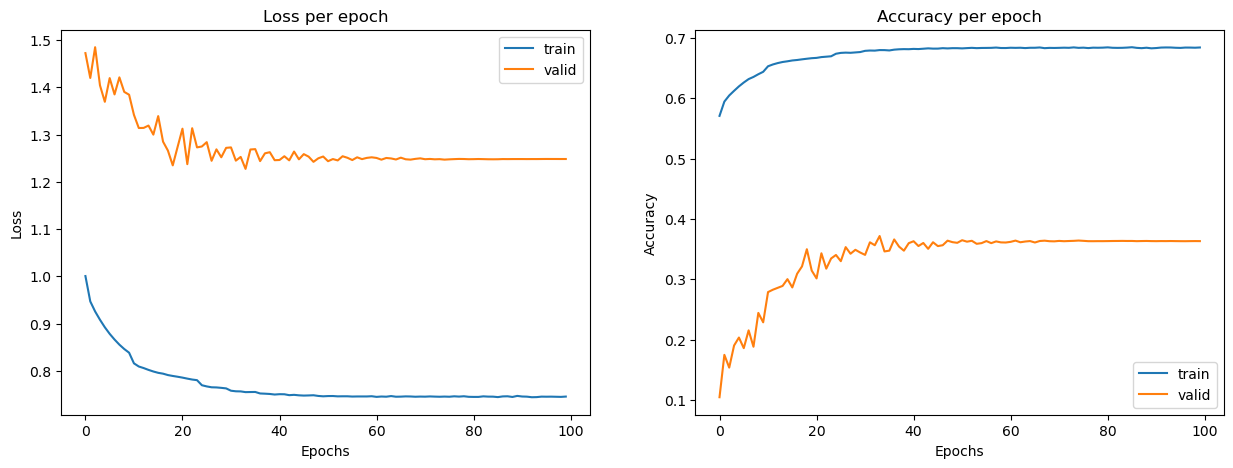

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     46137
           1       0.13      0.55      0.22      3050
           2       0.42      0.31      0.36     17500
           3       0.66      0.55      0.60     45097

    accuracy                           0.60    111784
   macro avg       0.49      0.55      0.48    111784
weighted avg       0.64      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35714  1733  1675   7015
1                 201  1682   748    419
2                1740  5064  5447   5249
3               11118  4089  5150  24740



 Accuracy :  60.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3893/3893 ━━━━━━━━━━━━━━━━━━━━ 4s 955us/step - loss: 1.0531 - sparse_categorical_accuracy: 0.5442 - val_loss: 1.4512 - val_sparse_categorical_accuracy: 0.1140 - learning_rate: 0.0010
Epoch 2/100
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 4s 944us/step - loss: 0.9570 - sparse_categorical_accuracy: 0.5891 - val_loss: 1.5266 - val_sparse_categorical_accuracy: 0.1244 - learning_rate: 0.0010
Epoch 3/100
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 4s 974us/step - loss: 0.9354 - sparse_categorical_accuracy: 0.5991 - val_loss: 1.4089 - val_sparse_categorical_accuracy: 0.1469 - learning_rate: 0.0010
Epoch 4/100
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 4s 971us/step - loss: 0.9216 - sparse_categorical_accuracy: 0.6047 - val_loss: 1.4226 - val_sparse_categorical_accuracy: 0.1686 - learning_rate: 0.0010
Epoch 5/100
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 4s 967us/step - loss: 0.9059 - sparse_categorical_accuracy: 0.6138 - val_loss: 1.4127 - val_sparse_categorical_accuracy: 0.1932 - learning_rate: 0.0010
Epoch 6/100
3893/3893 ━━━━━━━━━━━━━━━

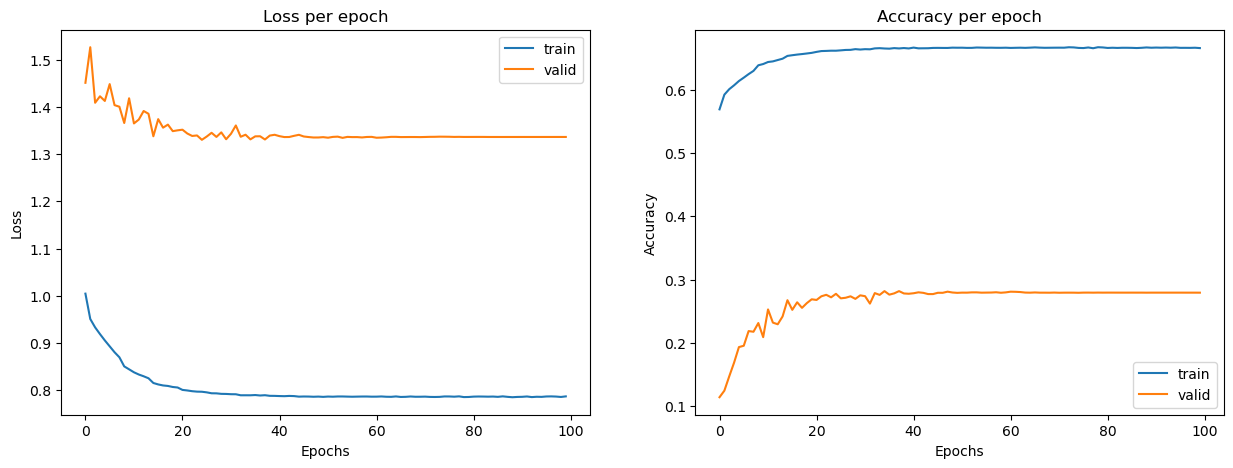

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.12      0.62      0.20      3050
           2       0.42      0.23      0.30     17500
           3       0.66      0.55      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.54      0.46    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35873  2157  1298   6809
1                 213  1900   524    413
2                1715  6288  4076   5421
3               11380  5222  3915  24580



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1947/1947 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0718 - sparse_categorical_accuracy: 0.5357 - val_loss: 1.4478 - val_sparse_categorical_accuracy: 0.1285 - learning_rate: 0.0010
Epoch 2/100
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9669 - sparse_categorical_accuracy: 0.5862 - val_loss: 1.4255 - val_sparse_categorical_accuracy: 0.1338 - learning_rate: 0.0010
Epoch 3/100
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 110s 56ms/step - loss: 0.9473 - sparse_categorical_accuracy: 0.5947 - val_loss: 1.4155 - val_sparse_categorical_accuracy: 0.1349 - learning_rate: 0.0010
Epoch 4/100
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9331 - sparse_categorical_accuracy: 0.6003 - val_loss: 1.4591 - val_sparse_categorical_accuracy: 0.1464 - learning_rate: 0.0010
Epoch 5/100
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 323s 166ms/step - loss: 0.9240 - sparse_categorical_accuracy: 0.6049 - val_loss: 1.4906 - val_sparse_categorical_accuracy: 0.1244 - learning_rate: 0.0010
Epoch 6/100
1947/1947 ━━━━━━━━━━━━━━━━━━

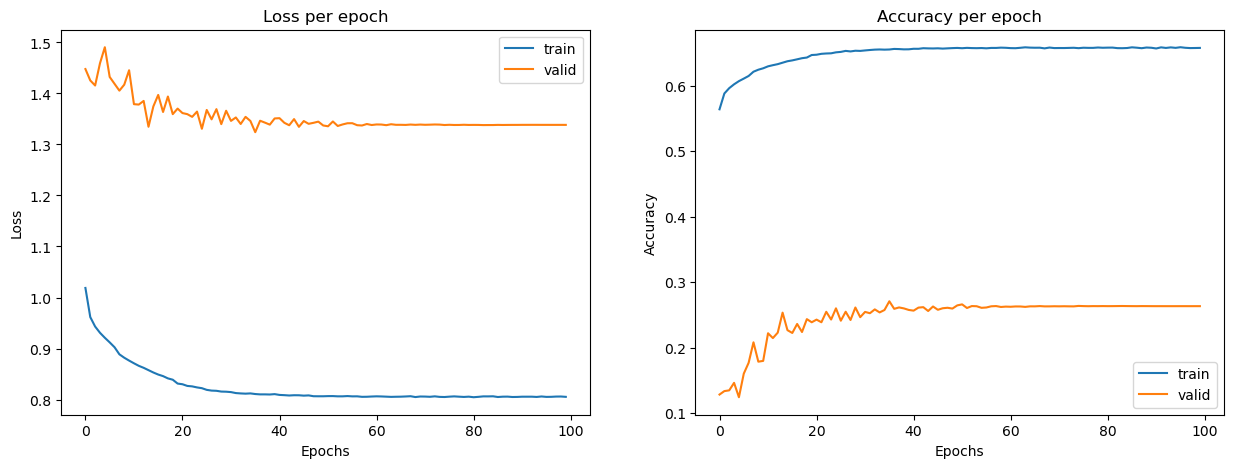

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.12      0.66      0.21      3050
           2       0.42      0.22      0.29     17500
           3       0.66      0.54      0.59     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.46    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36105  2350  1191   6491
1                 194  2015   453    388
2                1722  6609  3825   5344
3               11531  5608  3739  24219



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


974/974 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1035 - sparse_categorical_accuracy: 0.5165 - val_loss: 1.4796 - val_sparse_categorical_accuracy: 0.0909 - learning_rate: 0.0010
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9797 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.4418 - val_sparse_categorical_accuracy: 0.1293 - learning_rate: 0.0010
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 1078s 1s/step - loss: 0.9546 - sparse_categorical_accuracy: 0.5903 - val_loss: 1.4548 - val_sparse_categorical_accuracy: 0.1384 - learning_rate: 0.0010
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9420 - sparse_categorical_accuracy: 0.5958 - val_loss: 1.4350 - val_sparse_categorical_accuracy: 0.1535 - learning_rate: 0.0010
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 656s 675ms/step - loss: 0.9311 - sparse_categorical_accuracy: 0.6011 - val_loss: 1.4141 - val_sparse_categorical_accuracy: 0.1747 - learning_rate: 0.0010
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/ste

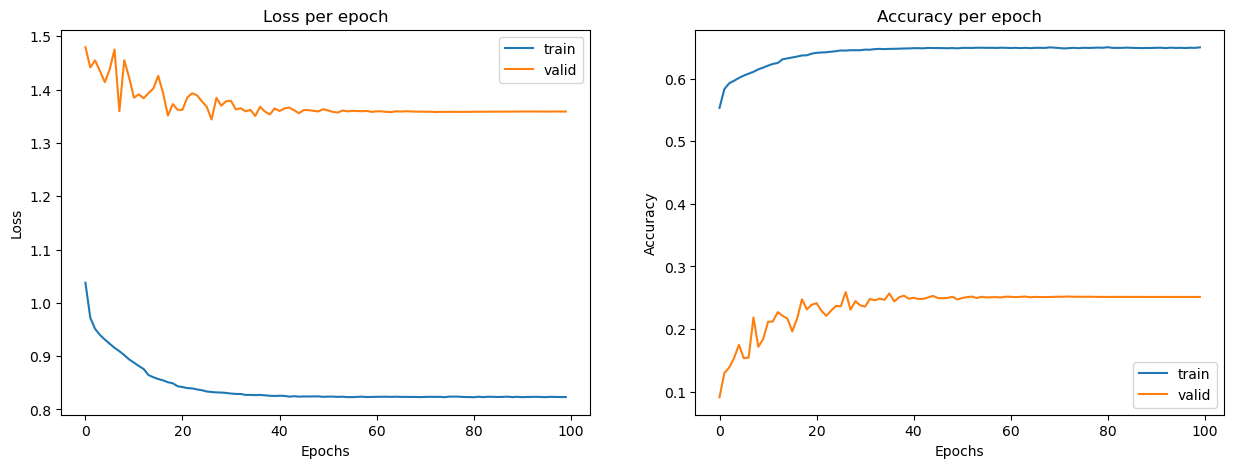

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.12      0.67      0.21      3050
           2       0.41      0.22      0.28     17500
           3       0.66      0.54      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.55      0.46    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35949  2401  1189   6598
1                 197  2054   403    396
2                1703  6710  3765   5322
3               11262  5680  3718  24437



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1403 - sparse_categorical_accuracy: 0.4938 - val_loss: 1.4970 - val_sparse_categorical_accuracy: 0.0720 - learning_rate: 0.0010
Epoch 2/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9958 - sparse_categorical_accuracy: 0.5740 - val_loss: 1.4308 - val_sparse_categorical_accuracy: 0.1142 - learning_rate: 0.0010
Epoch 3/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9710 - sparse_categorical_accuracy: 0.5841 - val_loss: 1.4754 - val_sparse_categorical_accuracy: 0.1098 - learning_rate: 0.0010
Epoch 4/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9543 - sparse_categorical_accuracy: 0.5907 - val_loss: 1.5138 - val_sparse_categorical_accuracy: 0.0877 - learning_rate: 0.0010
Epoch 5/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9439 - sparse_categorical_accuracy: 0.5951 - val_loss: 1.4563 - val_sparse_categorical_accuracy: 0.1362 - learning_rate: 0.0010
Epoch 6/100
487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

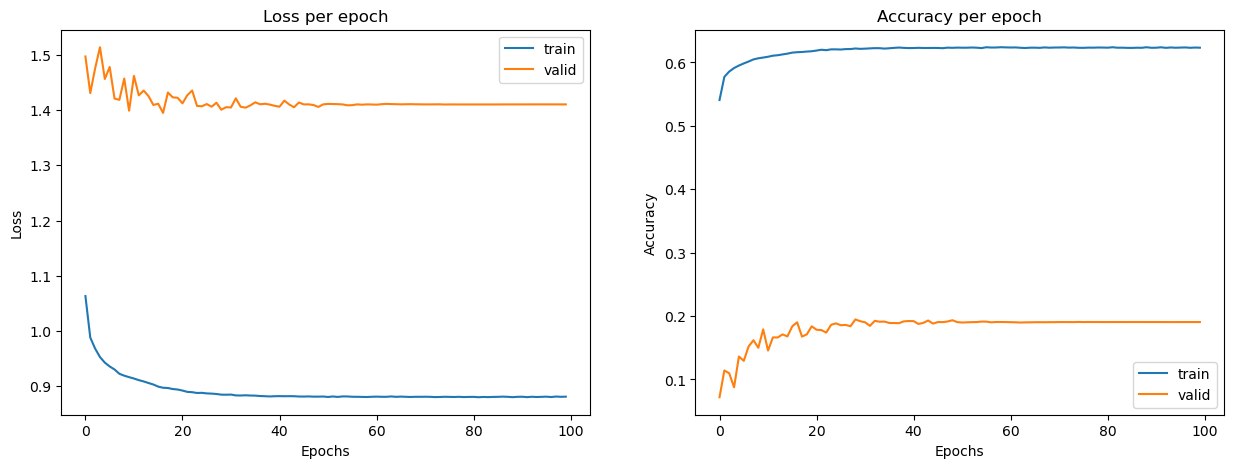

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 351s 100ms/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     46137
           1       0.11      0.73      0.20      3050
           2       0.43      0.16      0.24     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.55      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36120  2927   740   6350
1                 187  2241   248    374
2                1692  7699  2855   5254
3               11389  6696  2767  24245



 Accuracy :  59.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1706 - sparse_categorical_accuracy: 0.4770 - val_loss: 1.4858 - val_sparse_categorical_accuracy: 0.0668 - learning_rate: 0.0010
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0099 - sparse_categorical_accuracy: 0.5679 - val_loss: 1.4889 - val_sparse_categorical_accuracy: 0.0729 - learning_rate: 0.0010
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9859 - sparse_categorical_accuracy: 0.5779 - val_loss: 1.4476 - val_sparse_categorical_accuracy: 0.0988 - learning_rate: 0.0010
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9706 - sparse_categorical_accuracy: 0.5840 - val_loss: 1.4639 - val_sparse_categorical_accuracy: 0.1049 - learning_rate: 0.0010
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 0.9559 - sparse_categorical_accuracy: 0.5902 - val_loss: 1.3997 - val_sparse_categorical_accuracy: 0.1482 - learning_rate: 0.0010
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

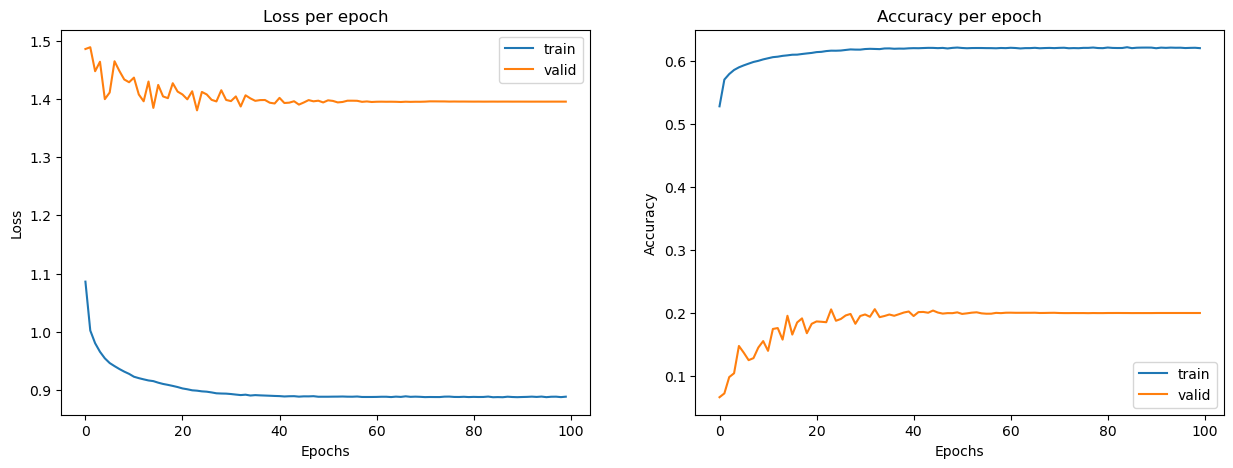

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     46137
           1       0.12      0.73      0.20      3050
           2       0.43      0.17      0.25     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.59    111784
   macro avg       0.49      0.56      0.45    111784
weighted avg       0.64      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36219  2760   788   6370
1                 179  2234   246    391
2                1638  7469  3033   5360
3               11407  6322  2913  24455



 Accuracy :  59.0


In [29]:
batchs = [32, 64, 128, 256, 512, 1024, 2048]

for batch in batchs :
    model5 = Sequential()
    model5.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dropout(rate = 0.2))
    model5.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dropout(rate = 0.2))
    model5.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
    model5.add(Dense(units = 4, activation = 'softmax'))

    model5.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history5 = model5.fit(X_train_ro, y_train_ro, epochs = 100, batch_size = batch, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec batch_size de :", batch)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history5.history['loss'], label = 'train')
    plt.plot(history5.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history5.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history5.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model5.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Les meilleurs résultats sont obtenus avec ub batch de 32.

### Modèle 6 : choix du nombre d'epochs

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.LecunNormal()

Epoch 1/10


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 563us/step - loss: 1.0302 - sparse_categorical_accuracy: 0.5572 - val_loss: 1.5599 - val_sparse_categorical_accuracy: 0.0912 - learning_rate: 0.0010
Epoch 2/10
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 549us/step - loss: 0.9441 - sparse_categorical_accuracy: 0.5963 - val_loss: 1.4395 - val_sparse_categorical_accuracy: 0.1552 - learning_rate: 0.0010
Epoch 3/10
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 546us/step - loss: 0.9215 - sparse_categorical_accuracy: 0.6068 - val_loss: 1.3530 - val_sparse_categorical_accuracy: 0.1901 - learning_rate: 0.0010
Epoch 4/10
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 550us/step - loss: 0.9006 - sparse_categorical_accuracy: 0.6170 - val_loss: 1.3892 - val_sparse_categorical_accuracy: 0.2189 - learning_rate: 0.0010
Epoch 5/10
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 551us/step - loss: 0.8816 - sparse_categorical_accuracy: 0.6231 - val_loss: 1.3783 - val_sparse_categorical_accuracy: 0.2197 - learning_rate: 0.0010
Epoch 6/10
15572/15572 ━━━━━━━━

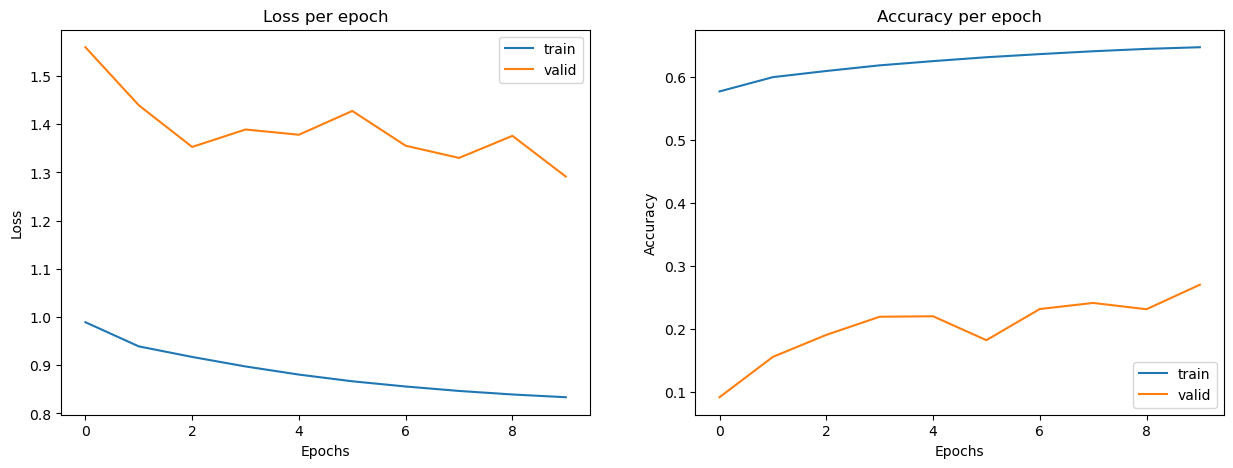

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 243us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.13      0.62      0.21      3050
           2       0.42      0.23      0.30     17500
           3       0.66      0.55      0.60     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.55      0.47    111784
weighted avg       0.63      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36156  2045  1252   6684
1                 226  1883   481    460
2                1779  5833  4088   5800
3               11582  4889  3861  24765



 Accuracy :  60.0
Epoch 1/20


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 564us/step - loss: 1.0314 - sparse_categorical_accuracy: 0.5553 - val_loss: 1.4097 - val_sparse_categorical_accuracy: 0.1231 - learning_rate: 0.0010
Epoch 2/20
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 551us/step - loss: 0.9457 - sparse_categorical_accuracy: 0.5942 - val_loss: 1.4012 - val_sparse_categorical_accuracy: 0.2095 - learning_rate: 0.0010
Epoch 3/20
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 551us/step - loss: 0.9222 - sparse_categorical_accuracy: 0.6064 - val_loss: 1.3743 - val_sparse_categorical_accuracy: 0.2087 - learning_rate: 0.0010
Epoch 4/20
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 558us/step - loss: 0.9030 - sparse_categorical_accuracy: 0.6146 - val_loss: 1.4590 - val_sparse_categorical_accuracy: 0.1612 - learning_rate: 0.0010
Epoch 5/20
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 554us/step - loss: 0.8857 - sparse_categorical_accuracy: 0.6220 - val_loss: 1.4322 - val_sparse_categorical_accuracy: 0.2293 - learning_rate: 0.0010
Epoch 6/20
15572/15572 ━━━━━━━━

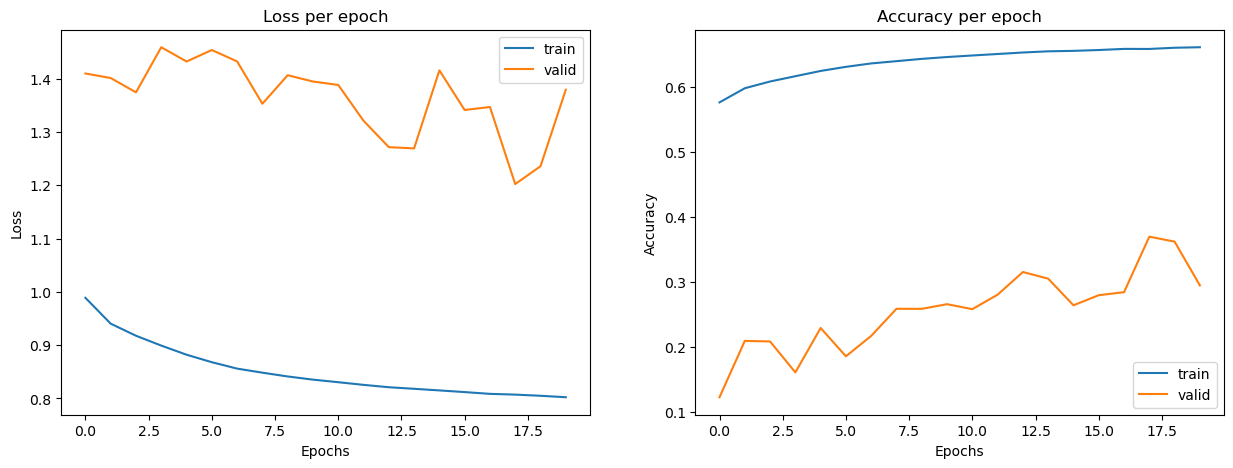

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     46137
           1       0.12      0.61      0.21      3050
           2       0.40      0.25      0.31     17500
           3       0.66      0.52      0.58     45097

    accuracy                           0.59    111784
   macro avg       0.48      0.54      0.46    111784
weighted avg       0.63      0.59      0.60    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36150  1988  1529   6470
1                 229  1864   562    395
2                1728  6091  4404   5277
3               11794  5103  4573  23627



 Accuracy :  59.0
Epoch 1/30


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 1.0347 - sparse_categorical_accuracy: 0.5550 - val_loss: 1.5465 - val_sparse_categorical_accuracy: 0.0699 - learning_rate: 0.0010
Epoch 2/30
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.9436 - sparse_categorical_accuracy: 0.5968 - val_loss: 1.4958 - val_sparse_categorical_accuracy: 0.1391 - learning_rate: 0.0010
Epoch 3/30
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 0.9203 - sparse_categorical_accuracy: 0.6081 - val_loss: 1.4200 - val_sparse_categorical_accuracy: 0.1673 - learning_rate: 0.0010
Epoch 4/30
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.8993 - sparse_categorical_accuracy: 0.6173 - val_loss: 1.4242 - val_sparse_categorical_accuracy: 0.1667 - learning_rate: 0.0010
Epoch 5/30
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.8836 - sparse_categorical_accuracy: 0.6239 - val_loss: 1.3334 - val_sparse_categorical_accuracy: 0.2021 - learning_rate: 0.0010
Epoch 6/30
15572/15572 ━━━━━━━━━━━━━

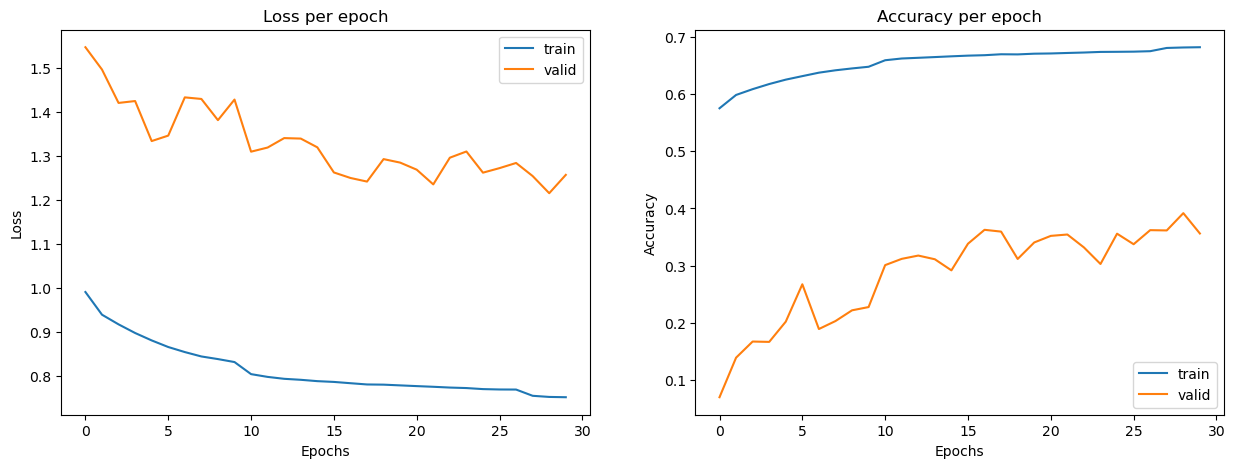

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 233us/step
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     46137
           1       0.13      0.56      0.22      3050
           2       0.41      0.30      0.35     17500
           3       0.65      0.56      0.60     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.55      0.48    111784
weighted avg       0.64      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35072  1670  1844   7551
1                 211  1703   706    430
2                1562  5206  5278   5454
3               10492  4060  5190  25355



 Accuracy :  60.0
Epoch 1/40


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 537us/step - loss: 1.0306 - sparse_categorical_accuracy: 0.5576 - val_loss: 1.4968 - val_sparse_categorical_accuracy: 0.0847 - learning_rate: 0.0010
Epoch 2/40
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 533us/step - loss: 0.9445 - sparse_categorical_accuracy: 0.5960 - val_loss: 1.4675 - val_sparse_categorical_accuracy: 0.1265 - learning_rate: 0.0010
Epoch 3/40
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 949s 61ms/step - loss: 0.9219 - sparse_categorical_accuracy: 0.6079 - val_loss: 1.3679 - val_sparse_categorical_accuracy: 0.2305 - learning_rate: 0.0010
Epoch 4/40
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 173s 11ms/step - loss: 0.9022 - sparse_categorical_accuracy: 0.6159 - val_loss: 1.3853 - val_sparse_categorical_accuracy: 0.2133 - learning_rate: 0.0010
Epoch 5/40
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - loss: 0.8848 - sparse_categorical_accuracy: 0.6241 - val_loss: 1.2851 - val_sparse_categorical_accuracy: 0.2768 - learning_rate: 0.0010
Epoch 6/40
15572/15572 ━━━━━━━

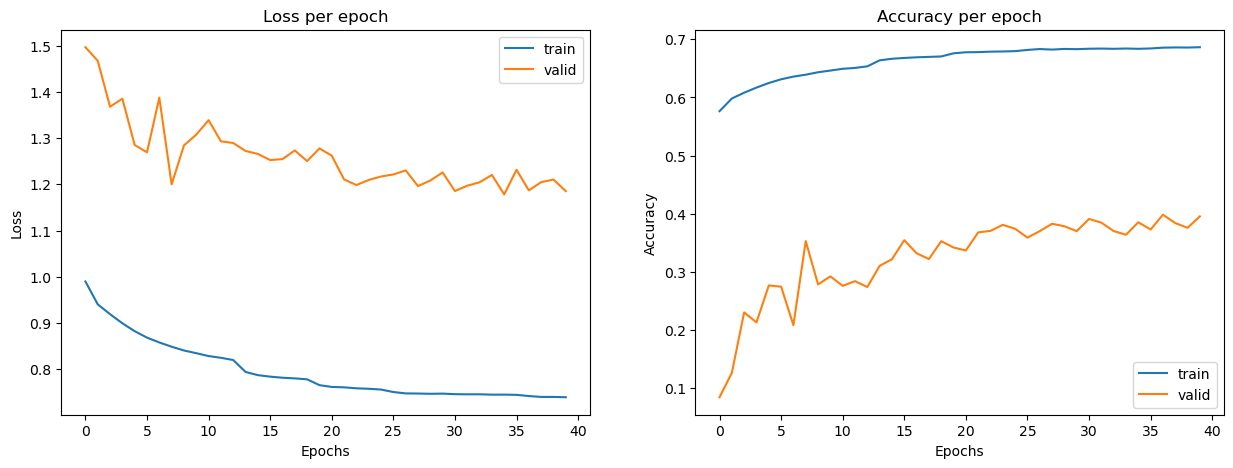

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
              precision    recall  f1-score   support

           0       0.73      0.76      0.75     46137
           1       0.13      0.54      0.21      3050
           2       0.39      0.34      0.36     17500
           3       0.66      0.53      0.59     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.48    111784
weighted avg       0.64      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35273  1735  2112   7017
1                 212  1656   823    359
2                1642  5205  5881   4772
3               10925  4056  6218  23898



 Accuracy :  60.0
Epoch 1/50


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 1559s 32ms/step - loss: 1.0281 - sparse_categorical_accuracy: 0.5572 - val_loss: 1.4565 - val_sparse_categorical_accuracy: 0.1303 - learning_rate: 0.0010
Epoch 2/50
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 553us/step - loss: 0.9429 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.4468 - val_sparse_categorical_accuracy: 0.1522 - learning_rate: 0.0010
Epoch 3/50
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 566us/step - loss: 0.9205 - sparse_categorical_accuracy: 0.6062 - val_loss: 1.4001 - val_sparse_categorical_accuracy: 0.1518 - learning_rate: 0.0010
Epoch 4/50
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 566us/step - loss: 0.8981 - sparse_categorical_accuracy: 0.6163 - val_loss: 1.4325 - val_sparse_categorical_accuracy: 0.1996 - learning_rate: 0.0010
Epoch 5/50
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 560us/step - loss: 0.8798 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.2731 - val_sparse_categorical_accuracy: 0.3068 - learning_rate: 0.0010
Epoch 6/50
15572/15572 ━━━━━━

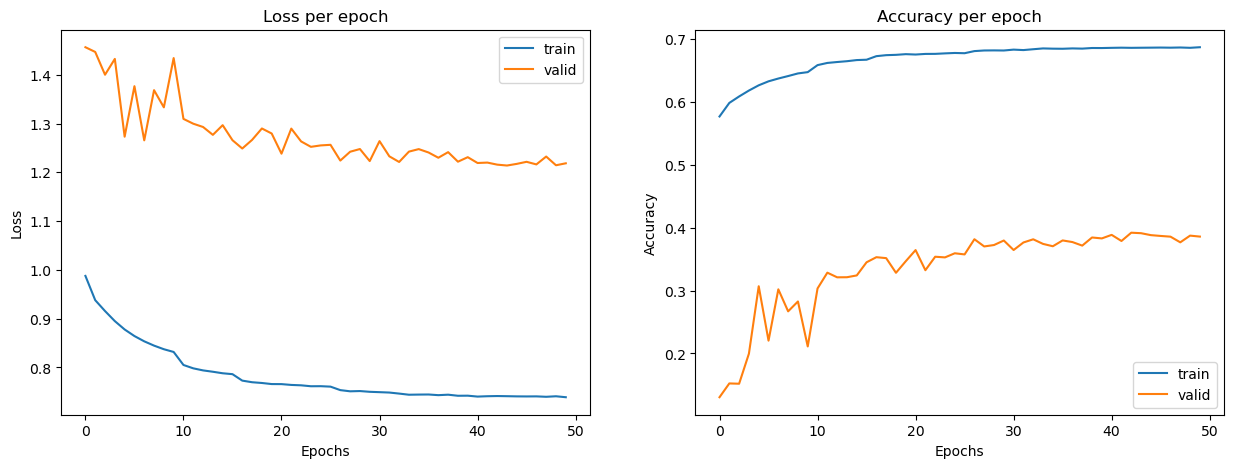

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     46137
           1       0.14      0.54      0.22      3050
           2       0.41      0.33      0.37     17500
           3       0.66      0.55      0.60     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.55      0.48    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35470  1501  1980   7186
1                 215  1640   757    438
2                1673  4887  5781   5159
3               10951  3811  5495  24840



 Accuracy :  61.0
Epoch 1/60


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 568us/step - loss: 1.0313 - sparse_categorical_accuracy: 0.5557 - val_loss: 1.4547 - val_sparse_categorical_accuracy: 0.1307 - learning_rate: 0.0010
Epoch 2/60
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 564us/step - loss: 0.9445 - sparse_categorical_accuracy: 0.5962 - val_loss: 1.4546 - val_sparse_categorical_accuracy: 0.1502 - learning_rate: 0.0010
Epoch 3/60
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 567us/step - loss: 0.9204 - sparse_categorical_accuracy: 0.6069 - val_loss: 1.4590 - val_sparse_categorical_accuracy: 0.1621 - learning_rate: 0.0010
Epoch 4/60
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 570us/step - loss: 0.9022 - sparse_categorical_accuracy: 0.6146 - val_loss: 1.3258 - val_sparse_categorical_accuracy: 0.2307 - learning_rate: 0.0010
Epoch 5/60
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 572us/step - loss: 0.8849 - sparse_categorical_accuracy: 0.6240 - val_loss: 1.3406 - val_sparse_categorical_accuracy: 0.2317 - learning_rate: 0.0010
Epoch 6/60
15572/15572 ━━━━━━━━

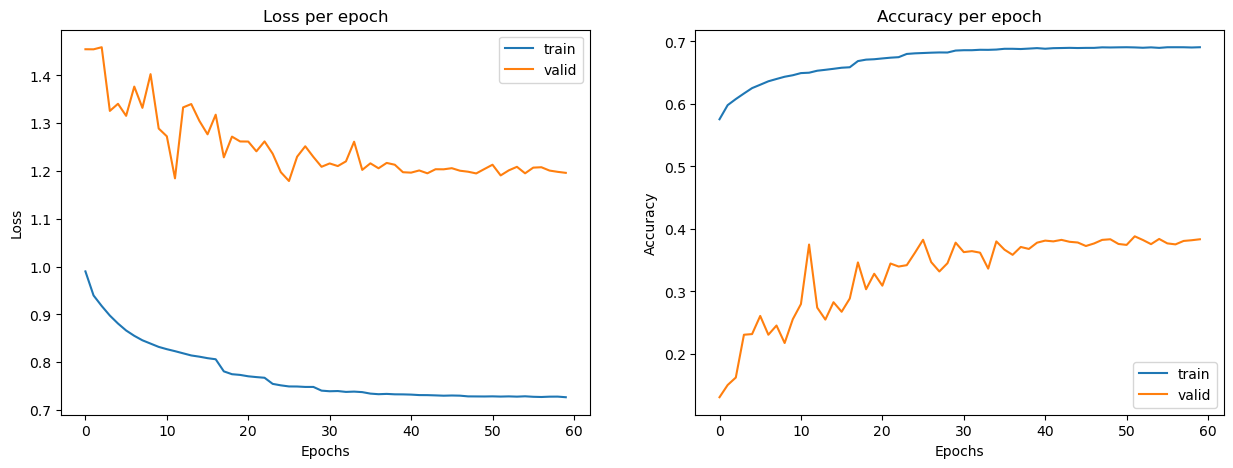

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 237us/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.75     46137
           1       0.14      0.53      0.22      3050
           2       0.40      0.33      0.36     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.48    111784
weighted avg       0.64      0.60      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36223  1581  1965   6368
1                 210  1629   773    438
2                1815  4854  5719   5112
3               11657  3698  5701  24041



 Accuracy :  60.0
Epoch 1/70


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 569us/step - loss: 1.0306 - sparse_categorical_accuracy: 0.5570 - val_loss: 1.5040 - val_sparse_categorical_accuracy: 0.0944 - learning_rate: 0.0010
Epoch 2/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 563us/step - loss: 0.9453 - sparse_categorical_accuracy: 0.5961 - val_loss: 1.4942 - val_sparse_categorical_accuracy: 0.1109 - learning_rate: 0.0010
Epoch 3/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 567us/step - loss: 0.9201 - sparse_categorical_accuracy: 0.6076 - val_loss: 1.3740 - val_sparse_categorical_accuracy: 0.2326 - learning_rate: 0.0010
Epoch 4/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 565us/step - loss: 0.8998 - sparse_categorical_accuracy: 0.6171 - val_loss: 1.3700 - val_sparse_categorical_accuracy: 0.2232 - learning_rate: 0.0010
Epoch 5/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 567us/step - loss: 0.8808 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.3873 - val_sparse_categorical_accuracy: 0.1977 - learning_rate: 0.0010
Epoch 6/70
15572/15572 ━━━━━━━━

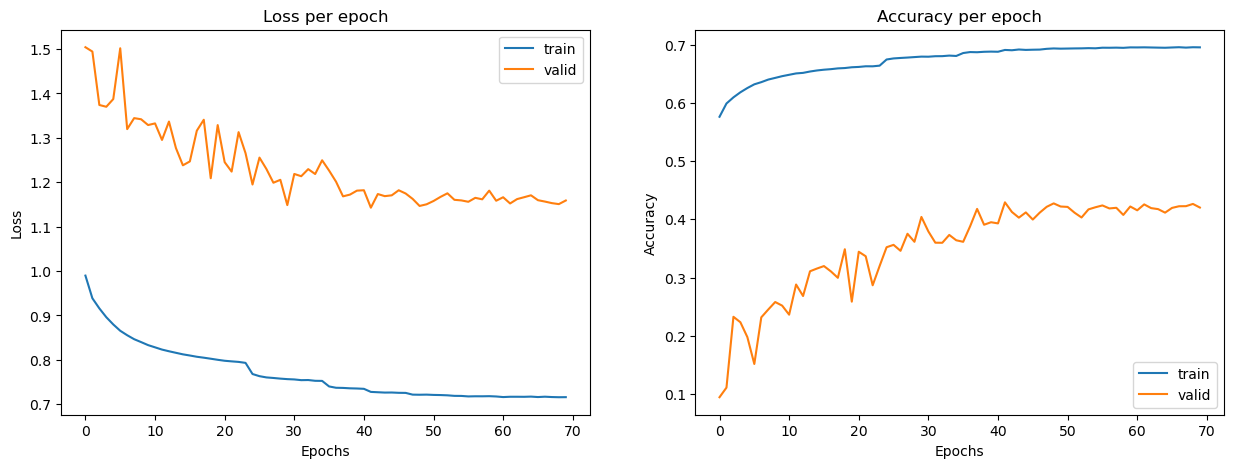

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     46137
           1       0.14      0.49      0.22      3050
           2       0.41      0.36      0.38     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.54      0.49    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35716  1431  2064   6926
1                 227  1509   921    393
2                1794  4494  6347   4865
3               11108  3369  6299  24321



 Accuracy :  61.0
Epoch 1/80


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 572us/step - loss: 1.0321 - sparse_categorical_accuracy: 0.5559 - val_loss: 1.3937 - val_sparse_categorical_accuracy: 0.1473 - learning_rate: 0.0010
Epoch 2/80
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 557us/step - loss: 0.9452 - sparse_categorical_accuracy: 0.5964 - val_loss: 1.4501 - val_sparse_categorical_accuracy: 0.1346 - learning_rate: 0.0010
Epoch 3/80
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 564us/step - loss: 0.9195 - sparse_categorical_accuracy: 0.6078 - val_loss: 1.4058 - val_sparse_categorical_accuracy: 0.2170 - learning_rate: 0.0010
Epoch 4/80
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 564us/step - loss: 0.9007 - sparse_categorical_accuracy: 0.6173 - val_loss: 1.3951 - val_sparse_categorical_accuracy: 0.2119 - learning_rate: 0.0010
Epoch 5/80
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 561us/step - loss: 0.8822 - sparse_categorical_accuracy: 0.6241 - val_loss: 1.4457 - val_sparse_categorical_accuracy: 0.1910 - learning_rate: 0.0010
Epoch 6/80
15521/15572 ━━━━━━━━

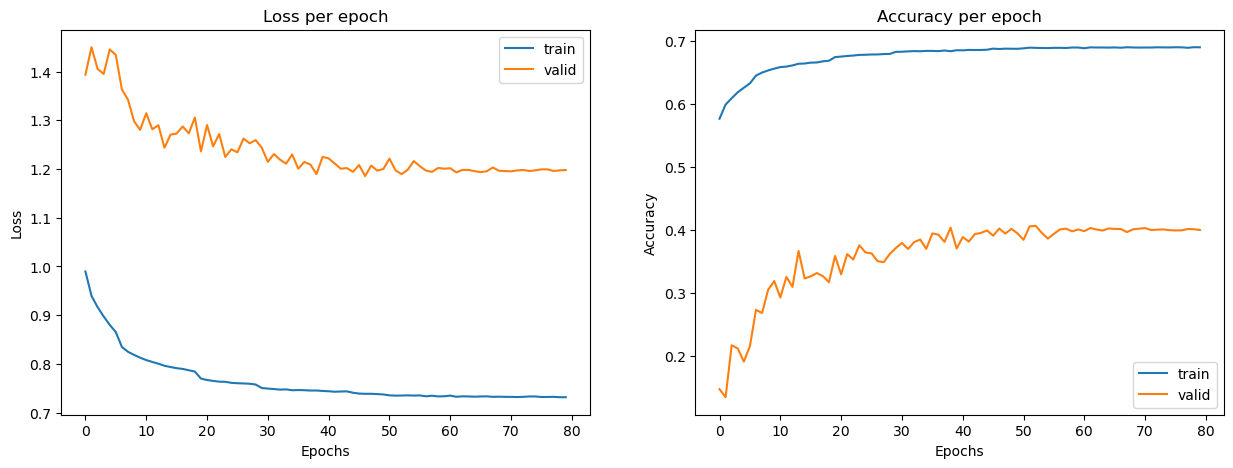

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.14      0.53      0.22      3050
           2       0.41      0.34      0.37     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.55      0.49    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36048  1573  1843   6673
1                 226  1612   817    395
2                1797  4744  5970   4989
3               11349  3701  5836  24211



 Accuracy :  61.0
Epoch 1/90


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 542us/step - loss: 1.0297 - sparse_categorical_accuracy: 0.5559 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.0808 - learning_rate: 0.0010
Epoch 2/90
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 530us/step - loss: 0.9455 - sparse_categorical_accuracy: 0.5946 - val_loss: 1.4692 - val_sparse_categorical_accuracy: 0.1294 - learning_rate: 0.0010
Epoch 3/90
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 530us/step - loss: 0.9232 - sparse_categorical_accuracy: 0.6055 - val_loss: 1.4161 - val_sparse_categorical_accuracy: 0.1535 - learning_rate: 0.0010
Epoch 4/90
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 319s 20ms/step - loss: 0.9019 - sparse_categorical_accuracy: 0.6158 - val_loss: 1.4348 - val_sparse_categorical_accuracy: 0.1927 - learning_rate: 0.0010
Epoch 5/90
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 531us/step - loss: 0.8882 - sparse_categorical_accuracy: 0.6208 - val_loss: 1.4252 - val_sparse_categorical_accuracy: 0.1728 - learning_rate: 0.0010
Epoch 6/90
15572/15572 ━━━━━━━

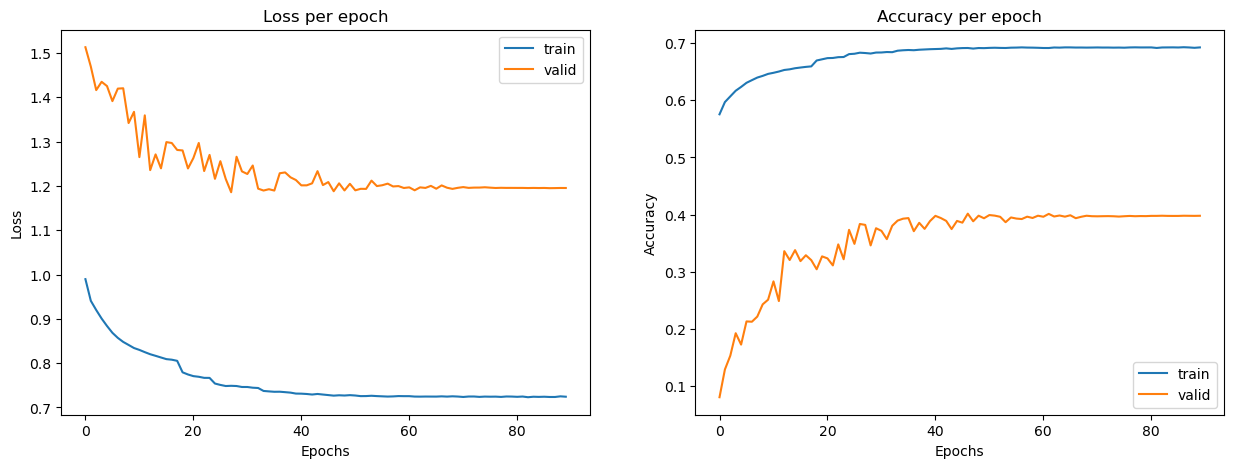

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.13      0.52      0.21      3050
           2       0.41      0.34      0.37     17500
           3       0.67      0.54      0.60     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.54      0.48    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35926  1611  1929   6671
1                 207  1586   831    426
2                1679  4867  5893   5061
3               11267  3774  5749  24307



 Accuracy :  61.0
Epoch 1/100


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 548us/step - loss: 1.0295 - sparse_categorical_accuracy: 0.5582 - val_loss: 1.3480 - val_sparse_categorical_accuracy: 0.2282 - learning_rate: 0.0010
Epoch 2/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 542us/step - loss: 0.9442 - sparse_categorical_accuracy: 0.5966 - val_loss: 1.5183 - val_sparse_categorical_accuracy: 0.1455 - learning_rate: 0.0010
Epoch 3/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 540us/step - loss: 0.9201 - sparse_categorical_accuracy: 0.6078 - val_loss: 1.3535 - val_sparse_categorical_accuracy: 0.2181 - learning_rate: 0.0010
Epoch 4/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 8s 541us/step - loss: 0.8962 - sparse_categorical_accuracy: 0.6177 - val_loss: 1.3691 - val_sparse_categorical_accuracy: 0.1897 - learning_rate: 0.0010
Epoch 5/100
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 551us/step - loss: 0.8781 - sparse_categorical_accuracy: 0.6271 - val_loss: 1.4328 - val_sparse_categorical_accuracy: 0.2103 - learning_rate: 0.0010
Epoch 6/100
15564/15572 ━━━

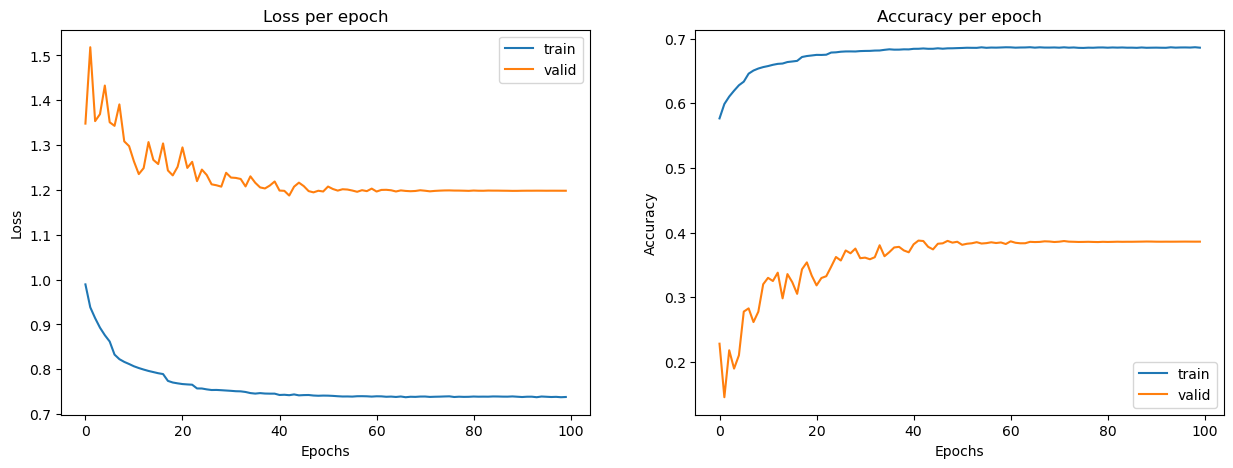

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
              precision    recall  f1-score   support

           0       0.72      0.79      0.76     46137
           1       0.14      0.52      0.22      3050
           2       0.41      0.33      0.37     17500
           3       0.67      0.53      0.59     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.54      0.48    111784
weighted avg       0.64      0.61      0.61    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               36502  1465  1776   6394
1                 219  1601   824    406
2                1815  4704  5806   5175
3               11840  3660  5614  23983



 Accuracy :  61.0


In [30]:
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for epoch in epochs :
    model6 = Sequential()
    model6.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dropout(rate = 0.2))
    model6.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
    model6.add(Dense(units = 4, activation = 'softmax'))

    model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
    history6 = model6.fit(X_train_ro, y_train_ro, epochs = epoch, batch_size = 32, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
    print("\n Modèle avec une epoch de :", epoch)
    
    plt.figure(figsize =(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history6.history['loss'], label = 'train')
    plt.plot(history6.history['val_loss'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss per epoch")

    plt.subplot(1, 2, 2)
    plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
    plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Accuracy per epoch")

    plt.show()
    test_pred = model6.predict(X_test)
    test_pred_class = test_pred.argmax(axis=1)

    # Affichage des résultats
    print(classification_report(y_test, test_pred_class), '\n\n')

    display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
    print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

Les meilleurs résultats sont obtenus avec une epoch de 70.

# Meilleur modèle

In [38]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.LecunNormal()

Epoch 1/70


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 10s 592us/step - loss: 1.0314 - sparse_categorical_accuracy: 0.5566 - val_loss: 1.4304 - val_sparse_categorical_accuracy: 0.1462 - learning_rate: 0.0010
Epoch 2/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 596us/step - loss: 0.9461 - sparse_categorical_accuracy: 0.5948 - val_loss: 1.3823 - val_sparse_categorical_accuracy: 0.2035 - learning_rate: 0.0010
Epoch 3/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 564us/step - loss: 0.9222 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.4489 - val_sparse_categorical_accuracy: 0.1681 - learning_rate: 0.0010
Epoch 4/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 569us/step - loss: 0.9012 - sparse_categorical_accuracy: 0.6164 - val_loss: 1.4172 - val_sparse_categorical_accuracy: 0.2135 - learning_rate: 0.0010
Epoch 5/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 585us/step - loss: 0.8839 - sparse_categorical_accuracy: 0.6245 - val_loss: 1.4023 - val_sparse_categorical_accuracy: 0.1888 - learning_rate: 0.0010
Epoch 6/70
15572/15572 ━━━━━━━

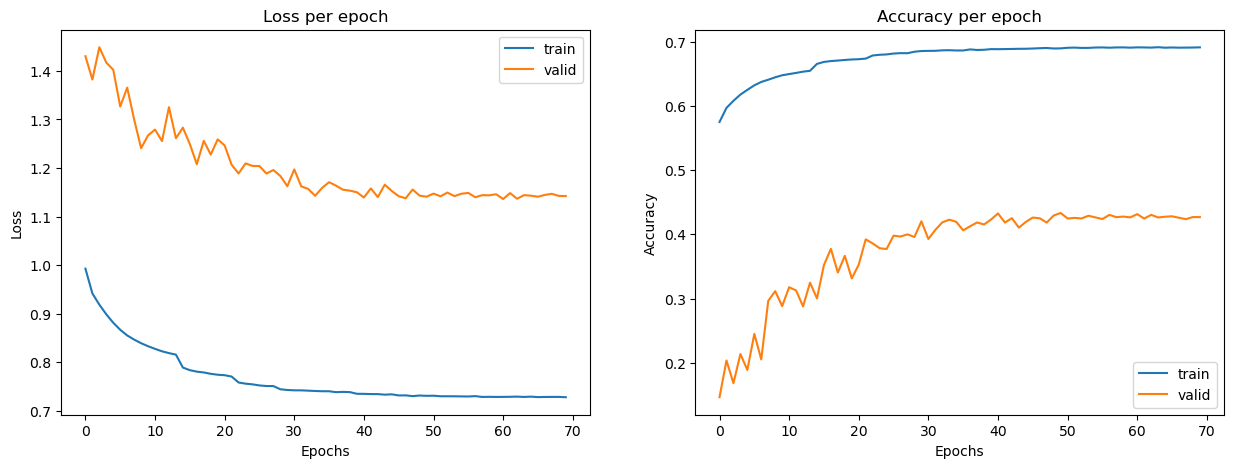

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 229us/step
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     46137
           1       0.14      0.49      0.22      3050
           2       0.41      0.37      0.39     17500
           3       0.67      0.54      0.59     45097

    accuracy                           0.61    111784
   macro avg       0.49      0.54      0.49    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0     1     2      3
Classe réelle                           
0               35768  1406  2179   6784
1                 223  1501   924    402
2                1723  4298  6474   5005
3               11261  3251  6359  24226



 Accuracy :  61.0


In [39]:
model6 = Sequential()
model6.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
model6.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 4, activation = 'softmax'))

model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
history6 = model6.fit(X_train_ro, y_train_ro, epochs = 70, batch_size = 32, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label = 'train')
plt.plot(history6.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()
test_pred = model6.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

# Réentrainement avec changement de l'ordre des modalités de 'grav' pour l'affichage streamlit

In [40]:
y_train_ro

0         3
1         3
2         3
3         2
4         3
         ..
553639    3
553640    3
553641    3
553642    3
553643    3
Name: grav, Length: 553644, dtype: int64

In [41]:
# Modification de l'odre des modalités de 'grav' : 0 - indemenes, 1 - blessés légers, 2 - blessés hospitalisés, 3 - tués
y_train_ro = y_train_ro.replace([0, 1, 2, 3], ['ind', 'tue', 'bh', 'bl'])
y_train_ro = y_train_ro.replace(['ind', 'tue', 'bh', 'bl'], [0, 3, 2, 1])

y_test = y_test.replace([0, 1, 2, 3], ['ind', 'tue', 'bh', 'bl'])
y_test = y_test.replace(['ind', 'tue', 'bh', 'bl'], [0, 3, 2, 1])

In [42]:
y_train_ro

0         1
1         1
2         1
3         2
4         1
         ..
553639    1
553640    1
553641    1
553642    1
553643    1
Name: grav, Length: 553644, dtype: int64

In [43]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False,
        ignore_class=None,
        reduction="sum_over_batch_size",
        name="sparse_categorical_crossentropy",
    )

kernel_initializer = tf.keras.initializers.LecunNormal()

Epoch 1/70


/Users/vanessaibert/anaconda3/envs/Projet/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15572/15572 ━━━━━━━━━━━━━━━━━━━━ 10s 578us/step - loss: 1.0358 - sparse_categorical_accuracy: 0.5531 - val_loss: 1.4794 - val_sparse_categorical_accuracy: 0.0836 - learning_rate: 0.0010
Epoch 2/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 555us/step - loss: 0.9469 - sparse_categorical_accuracy: 0.5945 - val_loss: 1.4900 - val_sparse_categorical_accuracy: 0.1348 - learning_rate: 0.0010
Epoch 3/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 555us/step - loss: 0.9234 - sparse_categorical_accuracy: 0.6049 - val_loss: 1.4384 - val_sparse_categorical_accuracy: 0.1712 - learning_rate: 0.0010
Epoch 4/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 551us/step - loss: 0.9012 - sparse_categorical_accuracy: 0.6151 - val_loss: 1.3935 - val_sparse_categorical_accuracy: 0.2213 - learning_rate: 0.0010
Epoch 5/70
15572/15572 ━━━━━━━━━━━━━━━━━━━━ 9s 554us/step - loss: 0.8857 - sparse_categorical_accuracy: 0.6233 - val_loss: 1.4218 - val_sparse_categorical_accuracy: 0.1882 - learning_rate: 0.0010
Epoch 6/70
15572/15572 ━━━━━━━

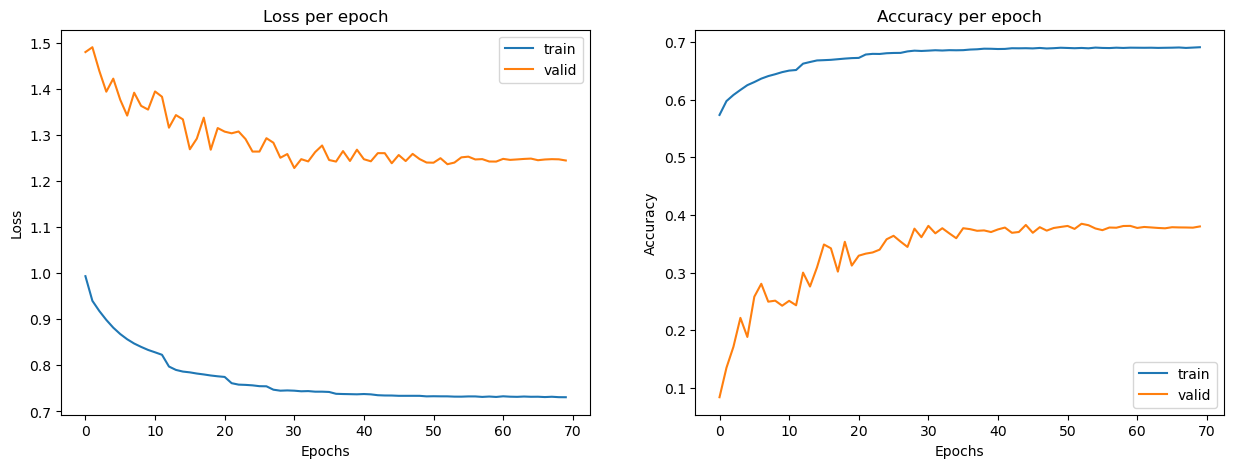

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1s 238us/step
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     46137
           1       0.65      0.58      0.61     45097
           2       0.42      0.33      0.37     17500
           3       0.14      0.51      0.22      3050

    accuracy                           0.61    111784
   macro avg       0.49      0.54      0.49    111784
weighted avg       0.64      0.61      0.62    111784
 




Classe prédite      0      1     2     3
Classe réelle                           
0               34984   7897  1878  1378
1               10461  26037  5193  3406
2                1599   5701  5752  4448
3                 198    484   824  1544



 Accuracy :  61.0


In [44]:
model6 = Sequential()
model6.add( Dense(units = 70, activation = "swish", input_shape = (X_train.shape[1],), kernel_initializer = kernel_initializer))
model6.add(Dense(units = 140, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add( Dense(units = 70, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 35, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dropout(rate = 0.2))
model6.add(Dense(units = 14, activation = "swish", kernel_initializer = kernel_initializer))
model6.add(Dense(units = 4, activation = 'softmax'))

model6.compile(loss = loss,
               optimizer = "adam",
               metrics = ['sparse_categorical_accuracy'])
    
history6 = model6.fit(X_train_ro, y_train_ro, epochs = 70, batch_size = 32, validation_split = 0.1, callbacks = [reduce_learning_rate])
    
plt.figure(figsize =(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label = 'train')
plt.plot(history6.history['val_loss'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.title("Loss per epoch")

plt.subplot(1, 2, 2)
plt.plot(history6.history['sparse_categorical_accuracy'], label = 'train')
plt.plot(history6.history['val_sparse_categorical_accuracy'], label = 'valid')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy per epoch")

plt.show()
test_pred = model6.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)

# Affichage des résultats
print(classification_report(y_test, test_pred_class), '\n\n')

display(pd.crosstab(y_test, test_pred_class, rownames = ['Classe réelle'], colnames = ['Classe prédite']))
    
print('\n\n Accuracy : ', np.round(accuracy_score(y_test, test_pred_class), 2)*100)

In [45]:
model6.save("../../../data/saved_models/dnn_oversampling.h5")